## Single generative script
IMP : This has to be merged with the previous one. Currently created to quickly generate all the different files.

NB : It was seen that running this with the previous code always crashes the kernel, but now it works.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Import custom modules
import src.data_loader as data_loader
import src.processor as processor

# Set matplotlib style
%matplotlib widget
%load_ext autoreload
%autoreload 2
plt.style.use('../anemotaxis.mplstyle')

In [2]:
def add_random_function():
    return None

In [2]:
def find_dates_in_base_path(base_path):
    """Find all date folders containing trx.mat files in the base path"""
    date_paths = []
    
    for root, dirs, files in os.walk(base_path):
        if "trx.mat" in files:
            date_str = os.path.basename(root)
            # Check if it's a date folder (format: YYYYMMDD_HHMMSS)
            if len(date_str) == 15 and date_str[8] == "_":
                date_paths.append({
                    'path': os.path.join(root, "trx.mat"),
                    'date_str': date_str
                })
    
    # Sort by date
    date_paths.sort(key=lambda x: x['date_str'])
    return date_paths

def process_single_date(trx_path, date_str):
    """Process a single date's tracking data"""
    print(f"Processing {date_str}...")
    
    # Process file
    date_str, extracted_data, metadata = data_loader.process_single_file(trx_path, show_progress=True)
    
    # Filter data
    filtered_data = processor.filter_larvae_by_duration(extracted_data, min_total_duration=300)
    filtered_data, stop_time_stats = processor.filter_larvae_by_excess_stop_time(
        filtered_data, max_stop_percentage=0.4
    )
    
    # Calculate behavior stats
    behavior_stats = processor.plot_behavior_duration_histograms(
        filtered_data, show_plot=False, using_frames=False
    )
    
    # Merge short stops
    merged_data, merge_summary = processor.merge_short_stop_sequences(
        filtered_data, behavior_stats,
        min_stop_duration_cast=3.0, min_stop_duration_run=3.0
    )
    
    print(f"  - {len(filtered_data)} larvae after filtering")
    print(f"  - {merge_summary['cast_stop_cast_count']} cast-stop-cast sequences merged")
    print(f"  - {merge_summary['run_stop_run_count']} run-stop-run sequences merged")
    
    return {
        'date_str': date_str,
        'raw_data': extracted_data,
        'filtered_data': filtered_data,
        'merged_data': merged_data,
        'behavior_stats': behavior_stats,
        'metadata': metadata
    }

def process_all_dates(base_path):
    """Process all date folders in the base path"""
    print(f"Finding date folders in {base_path}...")
    date_paths = find_dates_in_base_path(base_path)
    
    if not date_paths:
        print("No date folders with trx.mat found!")
        return None
    
    print(f"Found {len(date_paths)} dates with tracking data")
    
    # Process each date
    all_dates_data = {}
    for date_info in date_paths:
        date_str = date_info['date_str']
        trx_path = date_info['path']
        
        date_data = process_single_date(trx_path, date_str)
        all_dates_data[date_str] = date_data
    
    # Process all dates together
    print("\nProcessing all dates together...")
    all_data = data_loader.process_all_trx_files(base_path)
    
    # Filter and merge the combined data
    filtered_all_data = processor.filter_larvae_by_duration(all_data, min_total_duration=300)
    filtered_all_data, exp_stop_stats = processor.filter_larvae_by_excess_stop_time(
        filtered_all_data, max_stop_percentage=0.4
    )
    
    behavior_stats_all = processor.plot_behavior_duration_histograms(
        filtered_all_data, show_plot=False, using_frames=False
    )
    
    merged_all_data, merge_summary_all = processor.merge_short_stop_sequences(
        filtered_all_data, behavior_stats_all,
        min_stop_duration_cast=4.0, min_stop_duration_run=4.0
    )
    
    # Add combined data to the result
    all_dates_data['all_combined'] = {
        'date_str': 'All Combined',
        'raw_data': all_data,
        'filtered_data': filtered_all_data,
        'merged_data': merged_all_data,
        'behavior_stats': behavior_stats_all
    }
    
    return all_dates_data

def compute_orientation_tail_to_neck(x_tail, y_tail, x_neck, y_neck):
    """
    Compute orientation angle between tail-to-neck vector and negative x-axis.
    Returns angle in degrees, where 0° = facing -x (downstream), ±180° = +x (upstream).
    """
    v_x = x_neck - x_tail
    v_y = y_neck - y_tail
    angle_rad = np.arctan2(v_y, -v_x)  # -v_x for -x axis
    angle_deg = np.degrees(angle_rad)
    angle_deg = (angle_deg + 180) % 360 - 180
    return angle_deg

In [3]:
# Process all dates in the base path
# Set the base path - change this to analyze different genotypes
# base_path = "/Users/sharbat/Projects/anemotaxis/data/GMR_SS01948@UAS_TNT_2_0003/2s1x600s0s#n#n#n/"
# base_path = "/Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n"
# base_path = "/Users/sharbat/Projects/anemotaxis/data/GMR_SS01757@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n"
# base_path = "/Users/sharbat/Projects/anemotaxis/data/GMR_SS01948@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n"

base_path = "/Users/sharbat/Projects/anemotaxis/data/GMR_SS00864@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n"
# base_path = "/Users/sharbat/Projects/anemotaxis/data/GMR_SS01696@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n"
# base_path = "/Users/sharbat/Projects/anemotaxis/data/GMR_MB143B@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n"

# base_path = "/Users/sharbat/Desktop/Sharbat_DAN_data_June2025/FCF_attP2-40@UAS_TNT_2_0003" #june 2025 data new
# base_path = "/Users/sharbat/Desktop/Sharbat_DAN_data_June2025/GMR_00864@UAS_TNT_2_0003"
# Get genotype name for titles
genotype = os.path.basename(os.path.dirname(base_path))

# Create output directory
output_dir = f"../results/analysis/{genotype}"
os.makedirs(output_dir, exist_ok=True)

print(f"Analyzing data for {genotype}...")
all_dates_data = process_all_dates(base_path)

# Show summary of processed data
print("\nProcessed data summary:")
for date_key, date_data in all_dates_data.items():
    if date_key == 'all_combined':
        larvae_count = len(date_data['filtered_data']['data']) if 'data' in date_data['filtered_data'] else len(date_data['filtered_data'])
        print(f"All combined: {larvae_count} larvae after filtering")
    else:
        larvae_count = len(date_data['filtered_data'])
        print(f"{date_key}: {larvae_count} larvae after filtering")

Analyzing data for GMR_SS00864@UAS_TNT_2_0003...
Finding date folders in /Users/sharbat/Projects/anemotaxis/data/GMR_SS00864@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n...
Found 1 dates with tracking data
Processing 20240219_151622...

Processing file: /Users/sharbat/Projects/anemotaxis/data/GMR_SS00864@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/20240219_151622/trx.mat
Number of larvae: 58


Processing larvae:   0%|          | 0/58 [00:00<?, ?it/s]

Excess stop time filtering results (threshold: 40%):
  - Removed 2 larvae with >40% time in stop state
  - 21 larvae remaining

Large Behaviors duration analysis (seconds) for Multiple Experiments
Number of larvae: 21
Total actions: 1052

    Behavior   Events  %Total       Mean     Median        Std Above Mean  Above Med
-----------------------------------------------------------------------------------------------
         run:      506   48.1%      1.06       0.80       0.98       195        253
        cast:      291   27.7%      0.80       0.39       1.09        84        145
        stop:      141   13.4%      3.72       0.37      27.94         2         70
       hunch:       15    1.4%      0.29       0.26       0.15         5          7
      backup:       98    9.3%      0.63       0.62       0.32        44         49
        roll:        1    0.1%      1.28       1.28       0.00         0          0

Small Behaviors duration analysis (seconds) for Multiple Experiments
Number

Processing trx files:   0%|          | 0/1 [00:00<?, ?it/s]


Processed 1 files
Total larvae: 58
Excess stop time filtering results (threshold: 40%):
  - Removed 2 larvae with >40% time in stop state
  - 21 larvae remaining

Large Behaviors duration analysis (seconds) for All Experiments
Number of larvae: 21
Total actions: 1052

    Behavior   Events  %Total       Mean     Median        Std Above Mean  Above Med
-----------------------------------------------------------------------------------------------
         run:      506   48.1%      1.06       0.80       0.98       195        253
        cast:      291   27.7%      0.80       0.39       1.09        84        145
        stop:      141   13.4%      3.72       0.37      27.94         2         70
       hunch:       15    1.4%      0.29       0.26       0.15         5          7
      backup:       98    9.3%      0.63       0.62       0.32        44         49
        roll:        1    0.1%      1.28       1.28       0.00         0          0

Small Behaviors duration analysis (seconds) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.ndimage import gaussian_filter1d

def analyze_cast_orientations_all_true(trx_data, bin_width=10, show_plot=True, ax=None, sigma=2):
    """
    Analyze cast probability vs. orientation using tail-to-neck orientation.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.ndimage import gaussian_filter1d

    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        created_fig = True
    else:
        created_fig = False

    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    all_orientations = []
    all_is_cast = []

    for larva_id, larva_data in data_to_process.items():
        try:
            if 'global_state_large_state' not in larva_data:
                continue
            states = np.array(larva_data['global_state_large_state']).flatten()
            is_cast = states == 2

            # Use tail-to-neck orientation if available
            if all(k in larva_data for k in ['x_tail', 'y_tail', 'x_neck', 'y_neck']):
                x_tail = np.array(larva_data['x_tail']).flatten()
                y_tail = np.array(larva_data['y_tail']).flatten()
                x_neck = np.array(larva_data['x_neck']).flatten()
                y_neck = np.array(larva_data['y_neck']).flatten()
                min_len = min(len(x_tail), len(y_tail), len(x_neck), len(y_neck), len(states))
                x_tail = x_tail[:min_len]
                y_tail = y_tail[:min_len]
                x_neck = x_neck[:min_len]
                y_neck = y_neck[:min_len]
                is_cast = is_cast[:min_len]
                orientations = compute_orientation_tail_to_neck(x_tail, y_tail, x_neck, y_neck)
            # Fallback to head-tail if available
            elif all(k in larva_data for k in ['x_head', 'y_head', 'x_tail', 'y_tail']):
                x_head = np.array(larva_data['x_head']).flatten()
                y_head = np.array(larva_data['y_head']).flatten()
                x_tail = np.array(larva_data['x_tail']).flatten()
                y_tail = np.array(larva_data['y_tail']).flatten()
                min_len = min(len(x_head), len(y_head), len(x_tail), len(y_tail), len(states))
                x_head = x_head[:min_len]
                y_head = y_head[:min_len]
                x_tail = x_tail[:min_len]
                y_tail = y_tail[:min_len]
                is_cast = is_cast[:min_len]
                dx = x_head - x_tail
                dy = y_head - y_tail
                orientations = np.degrees(np.arctan2(dy, -dx))
            else:
                continue

            all_orientations.extend(orientations)
            all_is_cast.extend(is_cast)
        except Exception as e:
            print(f"Error processing larva {larva_id}: {str(e)}")

    if not all_orientations:
        ax.text(0.5, 0.5, "No cast orientation data available", ha='center', va='center', transform=ax.transAxes)
        return {'orientations': [], 'cast_prob': np.array([]), 'bin_centers': np.array([])}

    orientations = np.array(all_orientations)
    is_cast = np.array(all_is_cast)

    bins = np.arange(-180, 181, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    cast_prob = np.zeros_like(bin_centers, dtype=float)
    total_counts = np.zeros_like(bin_centers, dtype=int)

    for i in range(len(bin_centers)):
        bin_mask = (orientations >= bins[i]) & (orientations < bins[i+1])
        if np.any(bin_mask):
            total_counts[i] = np.sum(bin_mask)
            cast_prob[i] = np.sum(is_cast[bin_mask]) / total_counts[i]

    smoothed_prob = gaussian_filter1d(cast_prob, sigma=sigma)

    ax.plot(bin_centers, smoothed_prob, color='red', linewidth=2)
    ax.set_xlabel('Orientation (°)')
    ax.set_ylabel('Cast Probability')
    ax.set_xlim(-180, 180)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=180, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=-180, color='black', linestyle='--', alpha=0.5)

    if created_fig and show_plot:
        plt.tight_layout()
        plt.show()

    return {
        'bin_centers': bin_centers,
        'cast_prob': cast_prob,
        'smoothed_prob': smoothed_prob,
        'total_counts': total_counts
    }

def plot_global_behavior_matrix(trx_data, show_separate_totals=True, show_plot=True, ax=None):
    """
    Plot global behavior using the global state.
    
    This function visualizes behavioral states across time for all larvae.
    It processes both large_state (1-6) and small_large_state (0.5-5.5) values.
    
    Args:
        trx_data: Dictionary of larva data
        show_separate_totals: If True, show large, small, and total behaviors as separate rows
                             If False, show only a single row per larva
        show_plot: Whether to display the plot immediately
        ax: Optional matplotlib axes to plot on
    
    Returns:
        Behavior matrix or dict of processed data depending on mode
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    # Create axis if none provided
    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(12, 8))
        created_fig = True
    else:
        created_fig = False
    
    # Define state value mapping (both integer and half-integer values)
    # Maps state values to behavior names and colors
    state_mapping = {
        # Large behaviors (integer values)
        1.0: {'name': 'large_run', 'base': 'run', 'color': [0.0, 0.0, 0.0]},      # Black
        2.0: {'name': 'large_cast', 'base': 'cast', 'color': [1.0, 0.0, 0.0]},     # Red
        3.0: {'name': 'large_stop', 'base': 'stop', 'color': [0.0, 0.5, 0.0]},     # Green
        4.0: {'name': 'large_hunch', 'base': 'hunch', 'color': [0.0, 0.0, 1.0]},    # Blue
        5.0: {'name': 'large_backup', 'base': 'backup', 'color': [1.0, 0.5, 0.0]},   # Orange
        6.0: {'name': 'large_roll', 'base': 'roll', 'color': [0.5, 0.0, 0.5]},     # Purple
        
        # Small behaviors (half-integer values)
        0.5: {'name': 'small_run', 'base': 'run', 'color': [0.7, 0.7, 0.7]},      # Light gray
        1.5: {'name': 'small_cast', 'base': 'cast', 'color': [1.0, 0.7, 0.7]},     # Light red
        2.5: {'name': 'small_stop', 'base': 'stop', 'color': [0.7, 1.0, 0.7]},     # Light green
        3.5: {'name': 'small_hunch', 'base': 'hunch', 'color': [0.7, 0.7, 1.0]},    # Light blue
        4.5: {'name': 'small_backup', 'base': 'backup', 'color': [1.0, 0.8, 0.6]},   # Light orange
        5.5: {'name': 'small_roll', 'base': 'roll', 'color': [0.8, 0.6, 0.8]}      # Light purple
    }
    
    # Define total behavior colors (medium shade between large and small)
    total_behavior_colors = {
        'run': [0.4, 0.4, 0.4],       # Medium gray
        'cast': [0.8, 0.3, 0.3],      # Medium red
        'stop': [0.3, 0.8, 0.3],      # Medium green
        'hunch': [0.3, 0.3, 0.8],     # Medium blue
        'backup': [0.8, 0.6, 0.3],    # Medium orange
        'roll': [0.6, 0.3, 0.6]       # Medium purple
    }

    # Process larvae data
    if isinstance(trx_data, dict) and 'data' in trx_data:
        larvae_data = trx_data['data']
    else:
        larvae_data = trx_data
        
    larva_ids = sorted(larvae_data.keys())
    n_larvae = len(larva_ids)
    
    if n_larvae == 0:
        ax.text(0.5, 0.5, "No larvae data available", 
                ha='center', va='center', transform=ax.transAxes)
        return {}
    
    # Compute time ranges
    tmins = []
    tmaxs = []
    for lid in larva_ids:
        if 't' in larvae_data[lid] and len(larvae_data[lid]['t']) > 0:
            times = np.array(larvae_data[lid]['t']).flatten()
            if len(times) > 0:
                tmins.append(np.min(times))
                tmaxs.append(np.max(times))
    
    if not tmins:
        ax.text(0.5, 0.5, "No time data available", 
                ha='center', va='center', transform=ax.transAxes)
        return {}
    
    t_min = min(tmins)
    t_max = max(tmaxs)
    
    # Decide on plotting approach based on show_separate_totals
    if show_separate_totals:
        # Create full behavior matrix with colors (as in original function)
        resolution = 1000
        behavior_matrix = np.full((n_larvae * 3, resolution, 3), fill_value=1.0)  # white background
        
        # Process each larva
        for larva_idx, lid in enumerate(larva_ids):
            # Get time and state data
            if 't' not in larvae_data[lid] or len(larvae_data[lid]['t']) == 0:
                continue  # Skip larvae without required data
                
            larva_time = np.array(larvae_data[lid]['t']).flatten()
            
            # Use global_state_small_large_state if available, otherwise use global_state_large_state
            if 'global_state_small_large_state' in larvae_data[lid]:
                states = np.array(larvae_data[lid]['global_state_small_large_state']).flatten()
            elif 'global_state_large_state' in larvae_data[lid]:
                states = np.array(larvae_data[lid]['global_state_large_state']).flatten()
            else:
                continue  # Skip if no state data available
            
            # Ensure arrays have same length
            min_len = min(len(larva_time), len(states))
            if min_len == 0:
                continue
                
            larva_time = larva_time[:min_len]
            states = states[:min_len]
            
            # Convert times to indices
            time_indices = np.floor(
                ((larva_time - t_min) / (t_max - t_min) * (resolution - 1))
            ).astype(int)
            time_indices = np.clip(time_indices, 0, resolution - 1)

            # Arrays to store large, small and total behaviors
            large_behaviors = np.full((resolution, 3), fill_value=1.0)  # white background
            small_behaviors = np.full((resolution, 3), fill_value=1.0)  # white background
            total_behaviors = np.full((resolution, 3), fill_value=1.0)  # white background
            
            # For each unique time index, use the corresponding state
            unique_indices = np.unique(time_indices)
            for t_idx in unique_indices:
                mask = time_indices == t_idx
                if np.any(mask):
                    state_val = float(states[mask][0])  # Take first state if multiple exist
                    
                    # Round to nearest 0.5 to handle potential floating point issues
                    state_val = round(state_val * 2) / 2
                    
                    # Determine if this is a large or small behavior
                    is_large = state_val.is_integer()
                    is_small = not is_large
                    
                    # Assign colors based on state
                    if state_val in state_mapping:
                        behavior_info = state_mapping[state_val]
                        
                        if is_large:
                            large_behaviors[t_idx] = behavior_info['color']
                            total_behaviors[t_idx] = total_behavior_colors[behavior_info['base']]
                        elif is_small:
                            small_behaviors[t_idx] = behavior_info['color']
                            total_behaviors[t_idx] = total_behavior_colors[behavior_info['base']]
            
            # Assign the arrays to the behavior matrix
            row_large = larva_idx * 3
            row_small = larva_idx * 3 + 1
            row_total = larva_idx * 3 + 2
            
            behavior_matrix[row_large] = large_behaviors
            behavior_matrix[row_small] = small_behaviors
            behavior_matrix[row_total] = total_behaviors

        # Plot the behavior matrix
        ax.imshow(behavior_matrix, aspect='auto', interpolation='nearest', alpha=0.8,
                extent=[t_min, t_max, behavior_matrix.shape[0], 0])
        
        # Create y-tick labels
        ytick_positions = []
        ytick_labels = []
        
        for i, lid in enumerate(larva_ids):
            base_pos = i * 3
            # Position ticks in the middle of each row
            ytick_positions.extend([base_pos + 0.5, base_pos + 1.5, base_pos + 2.5])
            ytick_labels.extend([f"{lid} (large)", f"{lid} (small)", f"{lid} (total)"])
        
        ax.set_yticks(ytick_positions)
        ax.set_yticklabels(ytick_labels, fontsize='small')
        
        # Add horizontal lines to separate larvae
        for i in range(1, n_larvae):
            y_pos = i * 3
            ax.axhline(y=y_pos, color='black', linestyle='-', linewidth=0.5)
        
        # Add legend with all states
        legend_elements = []
        
        # Add large behaviors to legend
        for state_val in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]:
            if state_val in state_mapping:
                info = state_mapping[state_val]
                legend_elements.append(
                    Patch(facecolor=info['color'], 
                        label=f"{info['base']} (large)")
                )
        
        # Add a separator in the legend
        legend_elements.append(Patch(facecolor='white', label=''))
        
        # Add small behaviors to legend
        for state_val in [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]:
            if state_val in state_mapping:
                info = state_mapping[state_val]
                legend_elements.append(
                    Patch(facecolor=info['color'], 
                        label=f"{info['base']} (small)")
                )
        
        # Add a separator in the legend
        legend_elements.append(Patch(facecolor='white', label=''))
        
        # Add total behaviors to legend
        for base_name, color in total_behavior_colors.items():
            legend_elements.append(
                Patch(facecolor=color, label=f"{base_name} (total)")
            )
        
        # Add "Other" category
        legend_elements.append(Patch(facecolor=[1, 1, 1], label='Other'))
        
        ax.legend(handles=legend_elements, loc='center left', 
                bbox_to_anchor=(1, 0.5), title='Behavioral States')
        
    else:
        # Use the scatter plot approach for single row per larva, plotting ALL behaviors
        ytick_positions = []
        ytick_labels = []
        
        for i, larva_id in enumerate(larva_ids):
            if 'global_state_large_state' not in larvae_data[larva_id] or 't' not in larvae_data[larva_id]:
                continue  # Skip larvae without required data
            
            times = np.array(larvae_data[larva_id]['t']).flatten()
            states = np.array(larvae_data[larva_id]['global_state_large_state']).flatten()
            
            # Check if times are sorted
            if not np.all(np.diff(times) >= 0) and len(times) > 1:
                # Sort times and states
                sorted_indices = np.argsort(times)
                times = times[sorted_indices]
                states = states[sorted_indices]
            
            # Ensure both arrays have same length
            min_len = min(len(times), len(states))
            if min_len == 0:
                continue
                
            times = times[:min_len]
            states = states[:min_len]
            
            # Draw thin line across total time range
            ax.plot([times[0], times[-1]], [i, i], 'k-', linewidth=0.5, alpha=0.2)
            
            # Draw colored segments for each behavior state with appropriate colors
            # Plot ALL behaviors, not just run, cast, and stop
            for state_val in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]:
                if state_val in state_mapping:
                    info = state_mapping[state_val]
                    mask = states == state_val
                    if np.any(mask):
                        ax.scatter(times[mask], [i] * sum(mask), 
                                 color=info['color'], s=5, marker='s', alpha=0.8)
            
            ytick_positions.append(i)
            ytick_labels.append(str(larva_id))
        
        # Set axis properties
        ax.set_yticks(ytick_positions)
        ax.set_yticklabels(ytick_labels)
        
        # Add legend with all behavioral states
        legend_elements = []
        for state_val in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]:
            if state_val in state_mapping:
                info = state_mapping[state_val]
                legend_elements.append(
                    Line2D([0], [0], marker='s', color='w', 
                          markerfacecolor=info['color'], markersize=8, 
                          label=f"{info['base']}")
                )
        
        ax.legend(handles=legend_elements, loc='upper right')
    
    # Set common axis properties
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Larva ID')
    # Title removed as requested
    ax.set_xlim(t_min, t_max)
    
    # Only show if we created our own figure and show_plot is True
    if created_fig and show_plot:
        plt.tight_layout()
        plt.show()
    
    # Return the processed data
    result_data = {}
    for larva_id in larva_ids:
        if 'global_state_large_state' in larvae_data[larva_id] and 't' in larvae_data[larva_id]:
            result_data[larva_id] = {
                'times': np.array(larvae_data[larva_id]['t']).flatten(),
                'states': np.array(larvae_data[larva_id]['global_state_large_state']).flatten()
            }
    
    return result_data

def analyze_turn_rate_by_orientation_true(
    trx_data, bin_width=10, show_plot=True, ax=None, sigma=2, min_turn_amplitude=60
):
    """
    Analyze turn rate (turns/sec) vs orientation.
    A turn is defined as a cast (state==2 or state==1.5) that results in an orientation change >= min_turn_amplitude (deg).
    The orientation at which the turn occurs is the *initial* orientation at cast onset.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.ndimage import gaussian_filter1d

    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        created_fig = True
    else:
        created_fig = False

    if isinstance(trx_data, dict) and 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    bins = np.arange(-180, 181, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    turn_counts = np.zeros_like(bin_centers, dtype=float)
    total_time = np.zeros_like(bin_centers, dtype=float)

    for larva_id, larva_data in data_to_process.items():
        try:
            if 'global_state_large_state' not in larva_data or 't' not in larva_data:
                continue
            states = np.array(larva_data['global_state_large_state']).flatten()
            t = np.array(larva_data['t']).flatten()

            # Use tail-to-neck orientation if available
            if all(k in larva_data for k in ['x_tail', 'y_tail', 'x_neck', 'y_neck']):
                x_tail = np.array(larva_data['x_tail']).flatten()
                y_tail = np.array(larva_data['y_tail']).flatten()
                x_neck = np.array(larva_data['x_neck']).flatten()
                y_neck = np.array(larva_data['y_neck']).flatten()
                min_len = min(len(x_tail), len(y_tail), len(x_neck), len(y_neck), len(states), len(t))
                x_tail = x_tail[:min_len]
                y_tail = y_tail[:min_len]
                x_neck = x_neck[:min_len]
                y_neck = y_neck[:min_len]
                states = states[:min_len]
                t = t[:min_len]
                orientations = compute_orientation_tail_to_neck(x_tail, y_tail, x_neck, y_neck)
            else:
                continue

            # Find all cast (state==2 or state==1.5) segments
            i = 0
            while i < len(states):
                if states[i] == 2 or states[i] == 1.5:
                    cast_start = i
                    while i < len(states) and (states[i] == 2 or states[i] == 1.5):
                        i += 1
                    cast_end = i - 1
                    # Only consider casts with at least 2 frames
                    if cast_end > cast_start:
                        orient_start = orientations[cast_start]
                        orient_end = orientations[cast_end]
                        # Compute orientation change (handle wraparound)
                        delta = np.angle(np.exp(1j * np.deg2rad(orient_end - orient_start)), deg=True)
                        if np.abs(delta) >= min_turn_amplitude:
                            # Bin by initial orientation
                            for j in range(len(bin_centers)):
                                if bins[j] <= orient_start < bins[j+1]:
                                    turn_counts[j] += 1
                                    break
                else:
                    i += 1

            # Bin total time spent in each orientation (all frames)
            for j in range(len(bin_centers)):
                bin_mask = (orientations >= bins[j]) & (orientations < bins[j+1])
                t_bin = t[bin_mask]
                if len(t_bin) > 1:
                    total_time[j] += np.sum(np.diff(t_bin))
                elif len(t_bin) == 1 and len(t) > 1:
                    dt = np.median(np.diff(t))
                    total_time[j] += dt

        except Exception as e:
            print(f"Error processing larva {larva_id}: {str(e)}")

    # Compute turn rate per second
    turn_rate_per_sec = np.zeros_like(bin_centers, dtype=float)
    for j in range(len(bin_centers)):
        if total_time[j] > 0:
            turn_rate_per_sec[j] = turn_counts[j] / total_time[j]

    smoothed_rates = gaussian_filter1d(turn_rate_per_sec, sigma=sigma)

    if ax is not None:
        ax.plot(bin_centers, smoothed_rates, color='purple', linewidth=2)
        ax.set_xlabel('Orientation (°)')
        ax.set_ylabel('Turn Rate (turns/sec)')
        ax.set_xlim(-180, 180)
        ax.grid(True, alpha=0.3)
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        ax.axvline(x=180, color='black', linestyle='--', alpha=0.5)
        ax.axvline(x=-180, color='black', linestyle='--', alpha=0.5)
        if created_fig and show_plot:
            plt.tight_layout()
            plt.show()

    return {
        'bin_centers': bin_centers,
        'turn_counts': turn_counts,
        'total_time': total_time,
        'turn_rate_per_sec': turn_rate_per_sec,
        'smoothed_rates': smoothed_rates
    }

def get_orientation_array(larva_data):
    """
    Always compute orientation as tail-to-neck relative to -x axis.
    Returns None if required keys are missing.
    """
    required_keys = ['x_tail', 'y_tail', 'x_neck', 'y_neck']
    if all(k in larva_data for k in required_keys):
        x_tail = np.array(larva_data['x_tail']).flatten()
        y_tail = np.array(larva_data['y_tail']).flatten()
        x_neck = np.array(larva_data['x_neck']).flatten()
        y_neck = np.array(larva_data['y_neck']).flatten()
        min_len = min(len(x_tail), len(y_tail), len(x_neck), len(y_neck))
        return compute_orientation_tail_to_neck(
            x_tail[:min_len], y_tail[:min_len], x_neck[:min_len], y_neck[:min_len]
        )
    return None

def analyze_run_orientations_all(experiments_data, bin_width=10, show_plot=True, ax=None, sigma=2):
    """Analyze run orientations using tail-to-neck orientation definition."""
    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        created_fig = True
    else:
        created_fig = False

    all_run_orientations = []

    if isinstance(experiments_data, dict) and 'data' in experiments_data:
        data_to_process = experiments_data['data']
    else:
        data_to_process = experiments_data

    for larva_id, larva_data in data_to_process.items():
        try:
            if 'global_state_large_state' not in larva_data:
                continue
            states = np.array(larva_data['global_state_large_state']).flatten()
            runs = np.logical_or(states == 1, states == 0.5)
            if runs.sum() == 0:
                continue
            orientations = get_orientation_array(larva_data)
            if orientations is None:
                continue
            min_len = min(len(orientations), len(runs))
            orientations = orientations[:min_len]
            runs = runs[:min_len]
            all_run_orientations.extend(orientations[runs])
        except Exception as e:
            print(f"Error processing larva {larva_id}: {str(e)}")

    if not all_run_orientations:
        ax.text(0.5, 0.5, "No run orientation data available", ha='center', va='center', transform=ax.transAxes)
        return {'orientations': [], 'hist': np.array([]), 'bin_centers': np.array([])}

    bins = np.arange(-180, 181, bin_width)
    hist, bin_edges = np.histogram(all_run_orientations, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    smoothed_hist = gaussian_filter1d(hist, sigma=sigma)

    ax.plot(bin_centers, smoothed_hist, color='black', linewidth=2)
    ax.set_xlabel('Orientation (°)')
    ax.set_ylabel('Probability Density')
    ax.set_xlim(-180, 180)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=180, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=-180, color='black', linestyle='--', alpha=0.5)

    if created_fig and show_plot:
        plt.tight_layout()
        plt.show()

    return {'orientations': all_run_orientations, 'hist': hist, 'bin_centers': bin_centers, 'smoothed_hist': smoothed_hist}

def analyze_cast_orientations_all_new(trx_data, show_plot=True, ax=None, sigma=2):
    """Analyze cast orientations using tail-to-neck orientation definition."""
    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        created_fig = True
    else:
        created_fig = False

    all_cast_orientations = []

    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    for larva_id, larva_data in data_to_process.items():
        try:
            if 'global_state_large_state' not in larva_data:
                continue
            states = np.array(larva_data['global_state_large_state']).flatten()
            casts = states == 2
            if casts.sum() == 0:
                continue
            orientations = get_orientation_array(larva_data)
            if orientations is None:
                continue
            min_len = min(len(orientations), len(casts))
            orientations = orientations[:min_len]
            casts = casts[:min_len]
            all_cast_orientations.extend(orientations[casts])
        except Exception as e:
            print(f"Error processing larva {larva_id}: {str(e)}")

    if not all_cast_orientations:
        ax.text(0.5, 0.5, "No cast orientation data available", ha='center', va='center', transform=ax.transAxes)
        return {'orientations': [], 'hist': np.array([]), 'bin_centers': np.array([])}

    bins = np.arange(-180, 181, 10)
    hist, bin_edges = np.histogram(all_cast_orientations, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    smoothed_hist = gaussian_filter1d(hist, sigma=sigma)

    ax.plot(bin_centers, smoothed_hist, color='red', linewidth=2)
    ax.set_xlabel('Orientation (°)')
    ax.set_ylabel('Probability Density')
    ax.set_xlim(-180, 180)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=180, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=-180, color='black', linestyle='--', alpha=0.5)

    if created_fig and show_plot:
        plt.tight_layout()
        plt.show()

    return {
        'orientations': all_cast_orientations,
        'hist': hist,
        'bin_centers': bin_centers,
        'smoothed_hist': smoothed_hist
    }

def analyze_cast_orientations_all_true(trx_data, bin_width=10, show_plot=True, ax=None, sigma=2):
    """
    Analyze cast probability vs. orientation using tail-to-neck orientation.
    """
    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        created_fig = True
    else:
        created_fig = False

    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    all_orientations = []
    all_is_cast = []

    for larva_id, larva_data in data_to_process.items():
        try:
            if 'global_state_large_state' not in larva_data:
                continue
            states = np.array(larva_data['global_state_large_state']).flatten()
            is_cast = states == 2
            orientations = get_orientation_array(larva_data)
            if orientations is None:
                continue
            min_len = min(len(orientations), len(is_cast))
            orientations = orientations[:min_len]
            is_cast = is_cast[:min_len]
            all_orientations.extend(orientations)
            all_is_cast.extend(is_cast)
        except Exception as e:
            print(f"Error processing larva {larva_id}: {str(e)}")

    if not all_orientations:
        ax.text(0.5, 0.5, "No cast orientation data available", ha='center', va='center', transform=ax.transAxes)
        return {'orientations': [], 'cast_prob': np.array([]), 'bin_centers': np.array([])}

    orientations = np.array(all_orientations)
    is_cast = np.array(all_is_cast)

    bins = np.arange(-180, 181, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    cast_prob = np.zeros_like(bin_centers, dtype=float)
    total_counts = np.zeros_like(bin_centers, dtype=int)

    for i in range(len(bin_centers)):
        bin_mask = (orientations >= bins[i]) & (orientations < bins[i+1])
        if np.any(bin_mask):
            total_counts[i] = np.sum(bin_mask)
            cast_prob[i] = np.sum(is_cast[bin_mask]) / total_counts[i]

    smoothed_prob = gaussian_filter1d(cast_prob, sigma=sigma)

    ax.plot(bin_centers, smoothed_prob, color='red', linewidth=2)
    ax.set_xlabel('Orientation (°)')
    ax.set_ylabel('Cast Probability')
    ax.set_xlim(-180, 180)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=180, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=-180, color='black', linestyle='--', alpha=0.5)

    if created_fig and show_plot:
        plt.tight_layout()
        plt.show()

    return {
        'bin_centers': bin_centers,
        'cast_prob': cast_prob,
        'smoothed_prob': smoothed_prob,
        'total_counts': total_counts
    }

def analyze_run_rate_by_orientation(experiments_data, bin_width=10, show_plot=True, ax=None, sigma=2):
    """
    Analyze run probability vs. orientation using tail-to-neck orientation.
    """
    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        created_fig = True
    else:
        created_fig = False

    all_orientations = []
    all_is_run = []

    if isinstance(experiments_data, dict) and 'data' in experiments_data:
        data_to_process = experiments_data['data']
    else:
        data_to_process = experiments_data

    for larva_id, larva_data in data_to_process.items():
        try:
            if 'global_state_large_state' not in larva_data:
                continue
            states = np.array(larva_data['global_state_large_state']).flatten()
            is_run = states == 1
            orientations = get_orientation_array(larva_data)
            if orientations is None:
                continue
            min_len = min(len(orientations), len(is_run))
            orientations = orientations[:min_len]
            is_run = is_run[:min_len]
            all_orientations.extend(orientations)
            all_is_run.extend(is_run)
        except Exception as e:
            print(f"Error processing larva {larva_id}: {str(e)}")

    if not all_orientations:
        ax.text(0.5, 0.5, "No orientation data available", ha='center', va='center', transform=ax.transAxes)
        return {}

    orientations = np.array(all_orientations)
    is_run = np.array(all_is_run)

    bins = np.arange(-180, 181, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    run_probabilities = np.zeros_like(bin_centers, dtype=float)
    total_counts = np.zeros_like(bin_centers, dtype=int)

    for i in range(len(bin_centers)):
        bin_mask = (orientations >= bins[i]) & (orientations < bins[i+1])
        if np.any(bin_mask):
            total_counts[i] = np.sum(bin_mask)
            run_probabilities[i] = np.sum(is_run[bin_mask]) / total_counts[i]

    smoothed_probs = gaussian_filter1d(run_probabilities, sigma=sigma)

    ax.plot(bin_centers, smoothed_probs, color='black', linewidth=2)
    ax.set_xlabel('Orientation (°)')
    ax.set_ylabel('Run Probability')
    ax.set_xlim(-180, 180)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=180, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=-180, color='black', linestyle='--', alpha=0.5)

    if created_fig and show_plot:
        plt.tight_layout()
        plt.show()

    return {
        'bin_centers': bin_centers,
        'run_probabilities': run_probabilities,
        'smoothed_probabilities': smoothed_probs,
        'total_counts': total_counts
    }

def analyze_turn_rate_by_orientation_new(trx_data, bin_width=10, show_plot=True, ax=None, sigma=2):
    """
    Analyze turn rate vs orientation using tail-to-neck orientation.
    """
    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        created_fig = True
    else:
        created_fig = False

    if isinstance(trx_data, dict) and 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    bins = np.arange(-180, 181, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    turn_counts = np.zeros_like(bin_centers)
    total_counts = np.zeros_like(bin_centers)

    for larva_id, larva_data in data_to_process.items():
        try:
            if 'global_state_large_state' not in larva_data:
                continue
            states = np.array(larva_data['global_state_large_state']).flatten()
            orientations = get_orientation_array(larva_data)
            if orientations is None:
                continue
            min_len = min(len(orientations), len(states))
            orientations = orientations[:min_len]
            states = states[:min_len]

            is_turn = np.zeros(len(states), dtype=bool)
            for i in range(1, len(states)):
                if states[i-1] == 1 and states[i] == 2:
                    is_turn[i-1] = True

            for i in range(len(bin_centers)):
                bin_mask = (orientations >= bins[i]) & (orientations < bins[i+1])
                if np.any(bin_mask):
                    bin_turn_count = np.sum(is_turn[bin_mask])
                    bin_total_count = np.sum(bin_mask)
                    turn_counts[i] += bin_turn_count
                    total_counts[i] += bin_total_count

        except Exception as e:
            print(f"Error processing larva {larva_id}: {str(e)}")

    if np.sum(total_counts) == 0:
        ax.text(0.5, 0.5, "No turn data available", ha='center', va='center', transform=ax.transAxes)
        return {}

    turn_rates = np.zeros_like(bin_centers, dtype=float)
    for i in range(len(bin_centers)):
        if total_counts[i] > 0:
            turn_rates[i] = turn_counts[i] / total_counts[i]

    smoothed_rates = gaussian_filter1d(turn_rates, sigma=sigma)

    ax.plot(bin_centers, smoothed_rates, color='red', linewidth=2)
    ax.set_xlabel('Orientation (°)')
    ax.set_ylabel('Turn Rate')
    ax.set_xlim(-180, 180)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=180, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=-180, color='black', linestyle='--', alpha=0.5)

    if created_fig and show_plot:
        plt.tight_layout()
        plt.show()

    return {
        'bin_centers': bin_centers,
        'turn_counts': turn_counts,
        'total_counts': total_counts,
        'turn_rates': turn_rates,
        'smoothed_rates': smoothed_rates
    }

def analyze_turn_amplitudes_by_orientation(trx_data, bin_width=10, show_plot=True, ax=None, sigma=2):
    """
    Analyze turn amplitudes vs orientation using tail-to-neck orientation.
    """
    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        created_fig = True
    else:
        created_fig = False

    if isinstance(trx_data, dict) and 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    bins = np.arange(-180, 181, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    amplitudes_by_bin = {center: [] for center in bin_centers}
    mean_amplitudes = np.zeros_like(bin_centers, dtype=float)

    for larva_id, larva_data in data_to_process.items():
        try:
            if 'global_state_large_state' not in larva_data:
                continue
            states = np.array(larva_data['global_state_large_state']).flatten()
            orientations = get_orientation_array(larva_data)
            if orientations is None:
                continue
            min_len = min(len(orientations), len(states))
            orientations = orientations[:min_len]
            states = states[:min_len]

            cast_starts = []
            for i in range(1, len(states)):
                if states[i-1] == 1 and states[i] == 2:
                    cast_starts.append(i-1)

            for start_idx in cast_starts:
                if start_idx >= len(orientations) - 1:
                    continue
                start_orient = orientations[start_idx]
                end_idx = start_idx + 1
                while end_idx < len(states) and states[end_idx] == 2:
                    end_idx += 1
                if end_idx >= len(orientations):
                    end_idx = len(orientations) - 1
                cast_orientations = orientations[start_idx:end_idx+1]
                if len(cast_orientations) > 1:
                    cast_orientations = np.unwrap(cast_orientations * np.pi/180) * 180/np.pi
                    amplitude = np.max(cast_orientations) - np.min(cast_orientations)
                    for i, center in enumerate(bin_centers):
                        if bins[i] <= start_orient < bins[i+1]:
                            amplitudes_by_bin[center].append(amplitude)
                            break

        except Exception as e:
            print(f"Error processing larva {larva_id}: {str(e)}")

    has_data = any(len(amplitudes) > 0 for amplitudes in amplitudes_by_bin.values())
    if not has_data:
        ax.text(0.5, 0.5, "No cast amplitude data available", ha='center', va='center', transform=ax.transAxes)
        return {}

    for i, center in enumerate(bin_centers):
        if amplitudes_by_bin[center]:
            mean_amplitudes[i] = np.mean(amplitudes_by_bin[center])

    smoothed_amplitudes = gaussian_filter1d(mean_amplitudes, sigma=sigma)

    ax.plot(bin_centers, smoothed_amplitudes, color='red', linewidth=2)
    ax.set_xlabel('Orientation (°)')
    ax.set_ylabel('Mean Turn Amplitude (°)')
    ax.set_xlim(-180, 180)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=180, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=-180, color='black', linestyle='--', alpha=0.5)

    if created_fig and show_plot:
        plt.tight_layout()
        plt.show()

    return {
        'bin_centers': bin_centers,
        'mean_amplitudes': mean_amplitudes,
        'smoothed_amplitudes': smoothed_amplitudes,
        'amplitudes_by_bin': amplitudes_by_bin
    }

def analyze_velocity_by_orientation(trx_data, bin_width=10, show_plot=True, ax=None, sigma=2):
    """
    Analyze different velocity metrics by orientation using tail-to-neck orientation.
    Only considers velocities when larvae are in a running state.
    """
    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        created_fig = True
    else:
        created_fig = False

    if isinstance(trx_data, dict) and 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    bins = np.arange(-180, 181, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    motion_velocity_by_bin = {center: [] for center in bin_centers}
    head_velocity_by_bin = {center: [] for center in bin_centers}
    tail_velocity_by_bin = {center: [] for center in bin_centers}

    for larva_id, larva_data in data_to_process.items():
        try:
            if 'global_state_large_state' not in larva_data:
                continue
            states = np.array(larva_data['global_state_large_state']).flatten()
            is_run = np.logical_or(states == 1.0, states == 0.5)
            if not np.any(is_run):
                continue

            motion_velocity = np.array(larva_data['motion_velocity_norm_smooth_5']).flatten() if 'motion_velocity_norm_smooth_5' in larva_data else None
            head_velocity = np.array(larva_data['head_velocity_norm_smooth_5']).flatten() if 'head_velocity_norm_smooth_5' in larva_data else None
            tail_velocity = np.array(larva_data['tail_velocity_norm_smooth_5']).flatten() if 'tail_velocity_norm_smooth_5' in larva_data else None

            if motion_velocity is None and head_velocity is None and tail_velocity is None:
                continue

            orientations = get_orientation_array(larva_data)
            if orientations is None:
                continue

            lengths = [len(orientations), len(is_run)]
            if motion_velocity is not None:
                lengths.append(len(motion_velocity))
            if head_velocity is not None:
                lengths.append(len(head_velocity))
            if tail_velocity is not None:
                lengths.append(len(tail_velocity))
            min_len = min(lengths)
            if min_len <= 1:
                continue

            orientations = orientations[:min_len]
            is_run = is_run[:min_len]
            if motion_velocity is not None:
                motion_velocity = motion_velocity[:min_len]
            if head_velocity is not None:
                head_velocity = head_velocity[:min_len]
            if tail_velocity is not None:
                tail_velocity = tail_velocity[:min_len]

            run_orientations = orientations[is_run]
            run_motion_velocity = motion_velocity[is_run] if motion_velocity is not None else None
            run_head_velocity = head_velocity[is_run] if head_velocity is not None else None
            run_tail_velocity = tail_velocity[is_run] if tail_velocity is not None else None

            for i, center in enumerate(bin_centers):
                bin_mask = (run_orientations >= bins[i]) & (run_orientations < bins[i+1])
                if np.any(bin_mask):
                    if run_motion_velocity is not None:
                        motion_velocity_by_bin[center].extend(run_motion_velocity[bin_mask])
                    if run_head_velocity is not None:
                        head_velocity_by_bin[center].extend(run_head_velocity[bin_mask])
                    if run_tail_velocity is not None:
                        tail_velocity_by_bin[center].extend(run_tail_velocity[bin_mask])
        except Exception as e:
            print(f"Error processing larva {larva_id}: {str(e)}")

    has_motion_data = any(len(velocities) > 0 for velocities in motion_velocity_by_bin.values())
    has_head_data = any(len(velocities) > 0 for velocities in head_velocity_by_bin.values())
    has_tail_data = any(len(velocities) > 0 for velocities in tail_velocity_by_bin.values())

    if not (has_motion_data or has_head_data or has_tail_data):
        ax.text(0.5, 0.5, "No velocity data available during run states",
                ha='center', va='center', transform=ax.transAxes)
        return {}

    motion_velocity_means = np.zeros_like(bin_centers, dtype=float)
    head_velocity_means = np.zeros_like(bin_centers, dtype=float)
    tail_velocity_means = np.zeros_like(bin_centers, dtype=float)

    for i, center in enumerate(bin_centers):
        if motion_velocity_by_bin[center]:
            motion_velocity_means[i] = np.mean(motion_velocity_by_bin[center])
        if head_velocity_by_bin[center]:
            head_velocity_means[i] = np.mean(head_velocity_by_bin[center])
        if tail_velocity_by_bin[center]:
            tail_velocity_means[i] = np.mean(tail_velocity_by_bin[center])

    motion_velocity_smooth = gaussian_filter1d(motion_velocity_means, sigma=sigma) if has_motion_data else None
    head_velocity_smooth = gaussian_filter1d(head_velocity_means, sigma=sigma) if has_head_data else None
    tail_velocity_smooth = gaussian_filter1d(tail_velocity_means, sigma=sigma) if has_tail_data else None

    if has_motion_data:
        ax.plot(bin_centers, motion_velocity_smooth, color='blue', linewidth=2, label='Run motion velocity')
    if has_head_data:
        ax.plot(bin_centers, head_velocity_smooth, color='red', linewidth=2, label='Head velocity')
    if has_tail_data:
        ax.plot(bin_centers, tail_velocity_smooth, color='green', linewidth=2, label='Run tail velocity')

    ax.set_xlabel('Orientation (°)')
    ax.set_ylabel('Velocity (run state only)')
    ax.set_xlim(-180, 180)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=180, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=-180, color='black', linestyle='--', alpha=0.5)
    if has_motion_data or has_head_data or has_tail_data:
        ax.legend()

    if created_fig and show_plot:
        plt.tight_layout()
        plt.show()

    return {
        'bin_centers': bin_centers,
        'motion_velocity_means': motion_velocity_means,
        'head_velocity_means': head_velocity_means,
        'tail_velocity_means': tail_velocity_means,
        'motion_velocity_smooth': motion_velocity_smooth,
        'head_velocity_smooth': head_velocity_smooth,
        'tail_velocity_smooth': tail_velocity_smooth,
        'has_motion_data': has_motion_data,
        'has_head_data': has_head_data,
        'has_tail_data': has_tail_data
    }

In [5]:
def analyze_date(date_data, output_dir=None):
    """Create all analysis plots for a single date"""
    date_str = date_data['date_str']
    merged_data = date_data['merged_data']
    filtered_data = date_data['filtered_data']
    
    print(f"Analyzing {date_str}...")
    
    # Create figure with multiple plots
    fig = plt.figure(figsize=(10,8))
    fig.suptitle(f"Analysis for {date_str}", fontsize=16)
    gs = GridSpec(3, 3, figure=fig)
    
    # 1. Ethogram (spans the full first row)
    ax1 = fig.add_subplot(gs[0, :])
    plot_global_behavior_matrix(
        merged_data, show_separate_totals=False, show_plot=False, ax=ax1
    )
    
    # 2. Run orientation distribution
    ax2 = fig.add_subplot(gs[1, 0])
    analyze_run_orientations_all(
        merged_data, show_plot=False, ax=ax2
    )
    ax2.set_title("Run Orientation Distribution")
    
    # Update these calls in the analyze_date function
    # 3. Run probability by orientation
    ax3 = fig.add_subplot(gs[1, 1])
    analyze_run_rate_by_orientation(
        merged_data, bin_width=15, show_plot=False, ax=ax3
    )
    ax3.set_title("Run Probability vs Orientation")

    # 4. Turn rate by orientation
    ax4 = fig.add_subplot(gs[1, 2])
    analyze_turn_rate_by_orientation_true(
    merged_data, bin_width=15, show_plot=False, ax=ax4
)
    ax4.set_title("Turn Rate vs Orientation")

    
    # 5. Cast orientation analysis
    ax5 = fig.add_subplot(gs[2, 0])
    analyze_cast_orientations_all_true(
        merged_data, show_plot=False, ax=ax5
    )
    ax5.set_title("Cast Orientation Analysis")

    # 6. Cast amplitudes by orientation
    ax6 = fig.add_subplot(gs[2, 1])
    analyze_turn_amplitudes_by_orientation(
        merged_data, bin_width=15, show_plot=False, ax=ax6
    )

    ax6.set_title("Cast Amplitudes by Orientation")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)

        # 6. Cast amplitudes by orientation
    ax6 = fig.add_subplot(gs[2, 2])
    analyze_velocity_by_orientation(
        merged_data, bin_width=15, show_plot=False, ax=ax6
    )

    ax6.set_title("Velocities by Orientation")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    
    # Save figure if directory is provided
    if output_dir:
        # Create directory structure: {output_dir}/{date_str}/
        date_dir = os.path.join(output_dir, date_str)
        os.makedirs(date_dir, exist_ok=True)
        
        # Save in the date-specific directory
        save_path = os.path.join(date_dir, f"analysis_{date_str}.png")
        save_path_pdf = os.path.join(date_dir, f"analysis_{date_str}.pdf")
        plt.savefig(save_path)
        plt.savefig(save_path_pdf)
        print(f"Saved figure to {save_path}")
    
    plt.show()
    
    return fig

def plot_turn_rate_over_time(trx_data, window=60, step=10, show_plot=True, ax=None):
    """
    Plot orientation-independent turn rate (turns/min) across time.
    A turn is defined as a transition from run (1) to cast (2) in global_state_large_state.
    Args:
        trx_data: dict of larvae data (or {'data': ...})
        window: window size in seconds for rate calculation
        step: step size in seconds for moving window
        show_plot: whether to show the plot
        ax: matplotlib axis to plot on
    """
    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    # Collect all times for global windowing
    all_times = []
    for larva in data_to_process.values():
        if 't' in larva:
            t_arr = np.array(larva['t']).flatten()
            all_times.extend(t_arr.tolist())
    if not all_times:
        print("No time data found.")
        return
    t_min, t_max = np.min(all_times), np.max(all_times)
    time_bins = np.arange(t_min, t_max - window + step, step)
    turn_rates = np.zeros_like(time_bins, dtype=float)
    n_larvae = len(data_to_process)

    for i, t0 in enumerate(time_bins):
        t1 = t0 + window
        turns = 0
        total_time = 0
        for larva in data_to_process.values():
            if 't' not in larva or 'global_state_large_state' not in larva:
                continue
            t = np.array(larva['t']).flatten()
            states = np.array(larva['global_state_large_state']).flatten()
            mask = (t >= t0) & (t < t1)
            if np.sum(mask) < 2:
                continue
            t_win = t[mask]
            states_win = states[mask]
            # Count run->cast transitions
            turns += np.sum((states_win[:-1] == 1) & (states_win[1:] == 2))
            total_time += t_win[-1] - t_win[0]
        # Rate per minute per larva
        if total_time > 0 and n_larvae > 0:
            turn_rates[i] = turns / (total_time / 60) / n_larvae
        else:
            turn_rates[i] = np.nan

    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(8, 4))
    if ax is not None:
        ax.plot(time_bins + window/2, turn_rates)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Turn rate (turns/min/larva)')
        ax.set_title('Turn Rate Across Time')
    if show_plot and ax is None:
        plt.tight_layout()
        plt.show()
    return time_bins + window/2, turn_rates

def plot_run_probability_over_time(trx_data, window=60, step=10, show_plot=True, ax=None):
    """
    Plot orientation-independent run probability (probability of being in run state at each window) across time.
    Args:
        trx_data: dict of larvae data (or {'data': ...})
        window: window size in seconds for probability calculation
        step: step size in seconds for moving window
        show_plot: whether to show the plot
        ax: matplotlib axis to plot on
    """
    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    all_times = []
    for larva in data_to_process.values():
        if 't' in larva:
            t_arr = np.array(larva['t']).flatten()
            all_times.extend(t_arr.tolist())
    if not all_times:
        print("No time data found.")
        return
    t_min, t_max = np.min(all_times), np.max(all_times)
    time_bins = np.arange(t_min, t_max - window + step, step)
    run_probs = np.zeros_like(time_bins, dtype=float)
    n_larvae = len(data_to_process)

    for i, t0 in enumerate(time_bins):
        t1 = t0 + window
        n_run = 0
        n_total = 0
        for larva in data_to_process.values():
            if 't' not in larva or 'global_state_large_state' not in larva:
                continue
            t = np.array(larva['t']).flatten()
            states = np.array(larva['global_state_large_state']).flatten()
            mask = (t >= t0) & (t < t1)
            if np.sum(mask) < 1:
                continue
            states_win = states[mask]
            n_run += np.sum(states_win == 1)
            n_total += len(states_win)
        if n_total > 0:
            run_probs[i] = n_run / n_total
        else:
            run_probs[i] = np.nan

    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(8, 4))
    if ax is not None:
        ax.plot(time_bins + window/2, run_probs)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Run probability')
        ax.set_title('Run Probability Across Time')
    if show_plot and ax is None:
        plt.tight_layout()
        plt.show()
    return time_bins + window/2, run_probs

def plot_individual_larva_over_time_normalized(trx_data, window=60, step=10, show_plot=True, ax=None):
    """
    Plot each larva's turn rate and run probability across time, normalizing the time axis to [0, 1].
    Args:
        trx_data: dict of larvae data (or {'data': ...})
        window: window size in seconds for calculation
        step: step size in seconds for moving window
        show_plot: whether to show the plot
        ax: matplotlib axes (optional)
    """
    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    n_larvae = len(data_to_process)
    if n_larvae == 0:
        print("No larvae data found.")
        return

    # Prepare figure
    if ax is None and show_plot:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    elif ax is not None:
        axs = ax
    else:
        axs = [None, None]

    # Store all for mean
    all_turn_rates = []
    all_run_probs = []
    all_norm_time = []

    for larva_id, larva in data_to_process.items():
        if 't' not in larva or 'global_state_large_state' not in larva:
            continue
        t = np.array(larva['t']).flatten()
        states = np.array(larva['global_state_large_state']).flatten()
        if len(t) < 2:
            continue
        t_min, t_max = np.min(t), np.max(t)
        time_bins = np.arange(t_min, t_max - window + step, step)
        norm_time = (time_bins + window/2 - t_min) / (t_max - t_min) if (t_max - t_min) > 0 else np.zeros_like(time_bins)
        turn_rates = np.full_like(time_bins, np.nan, dtype=float)
        run_probs = np.full_like(time_bins, np.nan, dtype=float)
        for i, t0 in enumerate(time_bins):
            t1 = t0 + window
            mask = (t >= t0) & (t < t1)
            if np.sum(mask) < 2:
                continue
            t_win = t[mask]
            states_win = states[mask]
            # Turn rate: run->cast transitions per minute
            turns = np.sum((states_win[:-1] == 1) & (states_win[1:] == 2))
            total_time = t_win[-1] - t_win[0]
            if total_time > 0:
                turn_rates[i] = turns / (total_time / 60)
            # Run probability
            run_probs[i] = np.sum(states_win == 1) / len(states_win)
        # Store for mean
        all_turn_rates.append(turn_rates)
        all_run_probs.append(run_probs)
        all_norm_time.append(norm_time)
        # Plot individual
        if axs[0] is not None:
            axs[0].plot(norm_time, turn_rates, alpha=0.5, label=str(larva_id))
        if axs[1] is not None:
            axs[1].plot(norm_time, run_probs, alpha=0.5, label=str(larva_id))

    # Optionally plot mean (interpolate to common grid)
    common_grid = np.linspace(0, 1, 100)
    mean_turn = []
    mean_run = []
    for arr_list in [all_turn_rates, all_run_probs]:
        interp_vals = []
        for arr, tnorm in zip(arr_list, all_norm_time):
            mask = ~np.isnan(arr)
            if np.sum(mask) < 2:
                continue
            interp = np.interp(common_grid, tnorm[mask], arr[mask])
            interp_vals.append(interp)
        if interp_vals:
            mean = np.nanmean(np.vstack(interp_vals), axis=0)
        else:
            mean = np.full_like(common_grid, np.nan)
        if arr_list is all_turn_rates:
            mean_turn = mean
        else:
            mean_run = mean

    if axs[0] is not None:
        axs[0].plot(common_grid, mean_turn, color='purple', linewidth=2, label='Mean')
        axs[0].set_xlabel('Normalized Time')
        axs[0].set_ylabel('Turn rate (turns/min)')
        axs[0].set_title('Individual Turn Rate (normalized time)')
        axs[0].legend(loc='upper right', fontsize='small')
    if axs[1] is not None:
        axs[1].plot(common_grid, mean_run, color='black', linewidth=2, label='Mean')
        axs[1].set_xlabel('Normalized Time')
        axs[1].set_ylabel('Run probability')
        axs[1].set_title('Individual Run Probability (normalized time)')
        axs[1].legend(loc='upper right', fontsize='small')

    if show_plot and ax is None:
        plt.tight_layout()
        plt.show()

    return {
        'norm_time': all_norm_time,
        'turn_rates': all_turn_rates,
        'run_probs': all_run_probs,
        'mean_turn': mean_turn,
        'mean_run': mean_run,
        'common_grid': common_grid
    }

def plot_over_time_for_genotype(all_dates_data, window=60, step=10, output_dir=None):
    """
    Plot turn rate and run probability over time for each date (genotype).
    Saves plots if output_dir is provided.
    """
    for date_key, date_data in all_dates_data.items():
        date_str = date_data['date_str']
        merged_data = date_data['merged_data']

        fig = plt.figure(figsize=(12, 6))
        gs = GridSpec(1, 2, figure=fig)

        # Turn rate over time
        ax1 = fig.add_subplot(gs[0, 0])
        plot_turn_rate_over_time(merged_data, window=window, step=step, show_plot=False, ax=ax1)
        ax1.set_title("Turn Rate Across Time")

        # Run probability over time
        ax2 = fig.add_subplot(gs[0, 1])
        plot_run_probability_over_time(merged_data, window=window, step=step, show_plot=False, ax=ax2)
        ax2.set_title("Run Probability Across Time")

        # ax3 = fig.add_subplot(gs[1, 0])
        # ax4 = fig.add_subplot(gs[1, 1])
                
        # plot_individual_larva_over_time_normalized(merged_data, window=window, step=step, show_plot=False, ax=[ax3,ax4])
        # ax3.set_title("Run Probability Across Time")

        fig.suptitle(f"Over Time Analysis - {date_str}", fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)

        if output_dir:
            date_dir = os.path.join(output_dir, date_str)
            os.makedirs(date_dir, exist_ok=True)
            save_path = os.path.join(date_dir, f"over_time_{date_str}.png")
            plt.savefig(save_path)
            print(f"Saved over-time plot to {save_path}")

        plt.show()

In [6]:
def plot_individuals_over_time_absolute(
    trx_data, window=60, step=10, t_max=600, show_plot=True, ax=None
):
    """
    Plot each larva's turn rate, run probability, number of stops, number of headcasts, number of turns,
    and speed across absolute time (0 to t_max, e.g. 600s). Each larva's trace is plotted on the same time axis.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Prepare data
    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    n_larvae = len(data_to_process)
    if n_larvae == 0:
        print("No larvae data found.")
        return

    # Prepare figure
    if ax is None and show_plot:
        fig, axs = plt.subplots(2, 4, figsize=(22, 8))
        axs = axs.flatten()
    elif ax is not None:
        axs = ax
    else:
        axs = [None] * 8

    all_times = np.arange(0, t_max - window + step, step) + window / 2

    # Store for mean
    all_turn_rates = []
    all_run_probs = []
    all_n_stops = []
    all_n_headcasts = []
    all_n_turns = []
    all_speed = []

    for larva_id, larva in data_to_process.items():
        if 't' not in larva or 'global_state_large_state' not in larva:
            continue
        t = np.array(larva['t']).flatten()
        states = np.array(larva['global_state_large_state']).flatten()
        if len(t) < 2:
            continue

        is_stop = (states == 3) | (states == 2.5)
        is_headcast = (states == 4) | (states == 4.0) | (states == 4.5)

        # Speed: use 'motion_velocity_norm_smooth_5' if available, else None
        speed = np.array(larva['motion_velocity_norm_smooth_5']).flatten() if 'motion_velocity_norm_smooth_5' in larva else None

        turn_rates = np.full_like(all_times, np.nan, dtype=float)
        run_probs = np.full_like(all_times, np.nan, dtype=float)
        n_stops = np.full_like(all_times, np.nan, dtype=float)
        n_headcasts = np.full_like(all_times, np.nan, dtype=float)
        n_turns = np.full_like(all_times, np.nan, dtype=float)
        speed_vals = np.full_like(all_times, np.nan, dtype=float)

        for i, t_center in enumerate(all_times):
            t0 = t_center - window / 2
            t1 = t_center + window / 2
            mask = (t >= t0) & (t < t1)
            if np.sum(mask) < 2:
                continue
            t_win = t[mask]
            states_win = states[mask]
            turns = np.sum((states_win[:-1] == 1) & (states_win[1:] == 2))
            total_time = t_win[-1] - t_win[0]
            if total_time > 0:
                turn_rates[i] = turns / (total_time / 60)
            run_probs[i] = np.sum(states_win == 1) / len(states_win)
            n_stops[i] = np.sum(is_stop[mask])
            n_headcasts[i] = np.sum(is_headcast[mask])
            n_turns[i] = turns
            if speed is not None:
                speed_vals[i] = np.nanmean(speed[mask]) if np.any(mask) else np.nan

        all_turn_rates.append(turn_rates)
        all_run_probs.append(run_probs)
        all_n_stops.append(n_stops)
        all_n_headcasts.append(n_headcasts)
        all_n_turns.append(n_turns)
        all_speed.append(speed_vals)

        # Plot individual traces
        if axs[0] is not None:
            axs[0].plot(all_times, turn_rates, alpha=0.5, label=str(larva_id))
        if axs[1] is not None:
            axs[1].plot(all_times, run_probs, alpha=0.5, label=str(larva_id))
        if axs[2] is not None:
            axs[2].plot(all_times, n_stops, alpha=0.5, label=str(larva_id))
        if axs[3] is not None:
            axs[3].plot(all_times, n_headcasts, alpha=0.5, label=str(larva_id))
        if axs[4] is not None:
            axs[4].plot(all_times, n_turns, alpha=0.5, label=str(larva_id))
        if axs[5] is not None:
            axs[5].plot(all_times, speed_vals, alpha=0.5, label=str(larva_id))

    # Plot mean
    def plot_mean(ax, arrs, label, color):
        arrs = np.array(arrs)
        mean = np.nanmean(arrs, axis=0)
        ax.plot(all_times, mean, color=color, linewidth=2, label=label)

    if axs[0] is not None:
        plot_mean(axs[0], all_turn_rates, 'Mean', 'purple')
        axs[0].set_title('Turn Rate (turns/min)')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Turn Rate')
    if axs[1] is not None:
        plot_mean(axs[1], all_run_probs, 'Mean', 'black')
        axs[1].set_title('Run Probability')
        axs[1].set_xlabel('Time (s)')
        axs[1].set_ylabel('Run Probability')
    if axs[2] is not None:
        plot_mean(axs[2], all_n_stops, 'Mean', 'green')
        axs[2].set_title('Number of Stops')
        axs[2].set_xlabel('Time (s)')
        axs[2].set_ylabel('Stops')
    if axs[3] is not None:
        plot_mean(axs[3], all_n_headcasts, 'Mean', 'orange')
        axs[3].set_title('Number of Headcasts')
        axs[3].set_xlabel('Time (s)')
        axs[3].set_ylabel('Headcasts')
    if axs[4] is not None:
        plot_mean(axs[4], all_n_turns, 'Mean', 'blue')
        axs[4].set_title('Number of Turns')
        axs[4].set_xlabel('Time (s)')
        axs[4].set_ylabel('Turns')
    if axs[5] is not None:
        plot_mean(axs[5], all_speed, 'Mean', 'red')
        axs[5].set_title('Speed (mean)')
        axs[5].set_xlabel('Time (s)')
        axs[5].set_ylabel('Speed')

    # Hide unused subplot if present
    for i in range(6, len(axs)):
        if axs[i] is not None:
            axs[i].axis('off')

    if show_plot and ax is None:
        plt.tight_layout()
        plt.show()

    return {
        'times': all_times,
        'turn_rates': all_turn_rates,
        'run_probs': all_run_probs,
        'n_stops': all_n_stops,
        'n_headcasts': all_n_headcasts,
        'n_turns': all_n_turns,
        'speed': all_speed,
    }

def compute_time_in_run_and_cast(trx_data):
    """
    Compute total time spent in run and cast states for each larva.
    Returns a dict: {larva_id: {'run_time': ..., 'cast_time': ...}}
    """
    import numpy as np
    result = {}
    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    for larva_id, larva in data_to_process.items():
        if 't' not in larva or 'global_state_large_state' not in larva:
            continue
        t = np.array(larva['t']).flatten()
        states = np.array(larva['global_state_large_state']).flatten()
        min_len = min(len(t), len(states))
        t = t[:min_len]
        states = states[:min_len]
        dt = np.diff(t)
        run_mask = states[:-1] == 1
        cast_mask = states[:-1] == 2
        run_time = np.sum(dt[run_mask])
        cast_time = np.sum(dt[cast_mask])
        result[larva_id] = {'run_time': run_time, 'cast_time': cast_time}
    return result

def plot_time_in_run_and_cast_stacked(trx_data, show_plot=True, ax=None):
    """
    Plot total time spent in run and cast states for each larva as stacked bars,
    and show the average across all larvae as a separate bar.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    result = compute_time_in_run_and_cast(trx_data)
    larva_ids = list(result.keys())
    run_times = np.array([result[lid]['run_time'] for lid in larva_ids])
    cast_times = np.array([result[lid]['cast_time'] for lid in larva_ids])

    avg_run = np.mean(run_times)
    avg_cast = np.mean(cast_times)

    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(larva_ids))
    width = 0.6

    # Stacked bars for each larva
    ax.bar(x, run_times, width, label='Run Time', color='black')
    ax.bar(x, cast_times, width, bottom=run_times, label='Cast Time', color='red')

    # Average bar on the side
    ax.bar(len(larva_ids), avg_run, width, color='gray', label='Avg Run')
    ax.bar(len(larva_ids), avg_cast, width, bottom=avg_run, color='pink', label='Avg Cast')

    # X ticks and labels
    ax.set_xticks(list(x) + [len(larva_ids)])
    ax.set_xticklabels(larva_ids + ['Average'], rotation=90)
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Total Time in Run and Cast States per Larva (Stacked)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    if show_plot and ax is None:
        plt.tight_layout()
        plt.show()

    return ax

def plot_individuals_over_time_absolute_genotype(all_dates_data, window=60, step=10, t_max=600, output_dir=None):
    """
    For each date (genotype), plot all individuals' turn rate, run probability, number of stops,
    number of headcasts, and number of turns across absolute time (0 to t_max).
    Saves plots if output_dir is provided.
    Also fits a line through the means and displays the slope.
    """
    import numpy as np

    for date_key, date_data in all_dates_data.items():
        date_str = date_data['date_str']
        merged_data = date_data['merged_data']

        fig = plt.figure(figsize=(9, 8))
        gs = GridSpec(2, 3, figure=fig)
        axs = [fig.add_subplot(gs[i // 3, i % 3]) for i in range(6)]

        # Get the data and plot individuals
        results = plot_individuals_over_time_absolute(
            merged_data, window=window, step=step, t_max=t_max, show_plot=False, ax=axs
        )

        titles = [
            "Turn Rate (turns/min)",
            "Run Probability",
            "Number of Stops",
            "Number of Headcasts",
            "Number of Turns",
            "Speed (mean)"
        ]
        colors = ['purple', 'black', 'green', 'orange', 'blue','black']

        # Fit a line through the means and display the slope for each metric
        for i, (arrs, title, color) in enumerate(zip(
            [results['turn_rates'], results['run_probs'], results['n_stops'], results['n_headcasts'], results['n_turns'],results['speed']],
            titles, colors
        )):
            ax = axs[i]
            means = np.nanmean(np.array(arrs), axis=0)
            times = results['times']
            # Only fit where means are finite
            mask = np.isfinite(means)
            if np.sum(mask) > 1:
                # Fit line: y = m*x + b
                m, b = np.polyfit(times[mask], means[mask], 1)
                ax.plot(times, m*times + b, color=color, linestyle='--', linewidth=2, label=f'Fit (slope={m:.2e})')
                # Annotate slope in top left, scientific notation
                ax.text(0.02, 0.98, f"Slope: {m:.2e}", color=color, fontsize=16,
                        ha='left', va='top', transform=ax.transAxes)
            ax.set_title(title)

        fig.suptitle(f"Individuals Over Time - {date_str}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)

        if output_dir:
            date_dir = os.path.join(output_dir, date_str)
            os.makedirs(date_dir, exist_ok=True)
            save_path = os.path.join(date_dir, f"individuals_over_time_{date_str}.png")
            plt.savefig(save_path)
            print(f"Saved individuals-over-time plot to {save_path}")

        plt.show()

In [7]:
def plot_proba_global_state_over_time(trx_data, show_plot=True, ax=None):
    """
    Plot proba_global_state probabilities across time for each larva and the mean at each time point.
    Colors: run=black, cast=red, stop=green, hunch=blue, back=orange.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # State labels and colors
    state_labels = ["Run", "Cast", "Stop", "Hunch", "Back"]
    state_colors = ["black", "red", "green", "blue", "orange"]

    # Get larvae data
    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    # Find all possible states from the first larva
    first_larva = next(iter(data_to_process.values()))
    proba_shape = np.array(first_larva['proba_global_state']).shape if 'proba_global_state' in first_larva else None
    if proba_shape is None or proba_shape[0] != 5:
        print("No proba_global_state found or wrong shape.")
        print(proba_shape)
        return

    n_states = 5

    # Collect all t and proba arrays for each larva
    all_t = []
    all_probs = [[] for _ in range(n_states)]
    for larva_id, larva in data_to_process.items():
        if 't' not in larva or 'proba_global_state' not in larva:
            continue
        t = np.array(larva['t']).flatten()
        probs = np.array(larva['proba_global_state'])
        print(len(t), probs.shape)
        if probs.shape[0] != len(t) or probs.shape[1] != n_states:
            continue
        all_t.append(t)
        for i in range(n_states):
            all_probs[i].append(probs[:, i])

    # Compute mean probability for each state at each time point (by stacking and interpolating to common length if needed)
    # Here, just plot all traces and mean at each time point (if possible)
    # For mean, interpolate all to the shortest t vector length if needed
    min_len = min([len(t) for t in all_t]) if all_t else 0
    if min_len == 0:
        print("No valid time/proba data found.")
        return

    # Stack and compute mean for each state
    mean_probs = []
    for i in range(n_states):
        arrs = [arr[:min_len] for arr in all_probs[i]]
        if arrs:
            mean = np.nanmean(np.vstack(arrs), axis=0)
        else:
            mean = np.full(min_len, np.nan)
        mean_probs.append(mean)

    # Use the first t vector (truncated to min_len) for x axis
    time_grid = all_t[0][:min_len] if all_t else np.arange(min_len)

    # Plot
    if ax is None and show_plot:
        fig, axs = plt.subplots(n_states, 1, figsize=(10, 2.5 * n_states), sharex=True)
    elif ax is not None:
        axs = ax
    else:
        axs = [None] * n_states

    for i in range(n_states):
        ax_i = axs[i] if n_states > 1 else axs
        # Plot each larva
        for arr, t in zip(all_probs[i], all_t):
            ax_i.plot(t[:min_len], arr[:min_len], alpha=0.3, color=state_colors[i])
        # Plot mean
        ax_i.plot(time_grid, mean_probs[i], color=state_colors[i], linewidth=2, label=f'Mean {state_labels[i]}')
        ax_i.set_ylabel(f'P({state_labels[i]})')
        ax_i.legend()
        ax_i.grid(True, alpha=0.3)
    axs[-1].set_xlabel('Time (s)')
    if show_plot and ax is None:
        plt.tight_layout()
        plt.show()

    return {
        'time_grid': time_grid,
        'all_probs': all_probs,
        'mean_probs': mean_probs,
        'state_labels': state_labels
    }


def plot_proba_global_state_over_time_genotype(all_dates_data, output_dir=None, show_plot=True):
    """
    For each genotype/date, plot proba_global_state probabilities across time for each larva and the mean.
    Saves plots if output_dir is provided.
    """
    import os
    import matplotlib.pyplot as plt

    for date_key, date_data in all_dates_data.items():
        date_str = date_data['date_str']
        merged_data = date_data['merged_data']

        result = plot_proba_global_state_over_time(merged_data, show_plot=show_plot)

        if output_dir and result is not None:
            date_dir = os.path.join(output_dir, date_str)
            os.makedirs(date_dir, exist_ok=True)
            save_path = os.path.join(date_dir, f"proba_global_state_{date_str}.png")
            plt.savefig(save_path)
            print(f"Saved proba_global_state plot to {save_path}")
            plt.close()


In [8]:
def plot_global_state_over_time(trx_data, show_plot=True, ax=None, window=60, step=10, inset_hunch=True):
    """
    Plot the mean probability of each global_state_large_state (run=1, cast=2, stop=3, hunch=4, back=5)
    across time for the genotype (all larvae), showing only the mean trace for each state.
    Adds an inset showing hunch probability zoomed to [0, 0.1].
    """
    import numpy as np
    import matplotlib.pyplot as plt

    state_labels = ["Run", "Cast", "Stop", "Hunch", "Back"]
    state_values = [1, 2, 3, 4, 5]
    state_colors = ["black", "red", "green", "blue", "orange"]

    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    all_probs = [[] for _ in state_values]
    all_times = None

    # Compute windowed probabilities for each larva
    for larva_id, larva in data_to_process.items():
        if 't' not in larva or 'global_state_large_state' not in larva:
            continue
        t = np.array(larva['t']).flatten()
        states = np.array(larva['global_state_large_state']).flatten()
        if len(t) < 2:
            continue
        t_min, t_max = np.min(t), np.max(t)
        time_bins = np.arange(t_min, t_max - window + step, step)
        if all_times is None or len(time_bins) < len(all_times):
            all_times = time_bins + window / 2  # Use the shortest time vector for mean
        probs = np.full((len(time_bins), len(state_values)), np.nan)
        for i, t0 in enumerate(time_bins):
            t1 = t0 + window
            mask = (t >= t0) & (t < t1)
            if np.sum(mask) < 1:
                continue
            states_win = states[mask]
            for j, val in enumerate(state_values):
                probs[i, j] = np.sum(states_win == val) / len(states_win)
        for j in range(len(state_values)):
            all_probs[j].append(probs[:len(all_times), j])  # truncate to shortest

    if all_times is None or not any(len(arrs) > 0 for arrs in all_probs):
        print("No valid time/state data found.")
        return

    # Find the minimum length across all larvae for each state
    min_len = min([arr.shape[0] for arrs in all_probs for arr in arrs if len(arrs) > 0 and arr is not None])
    # Truncate all arrays to min_len
    mean_probs = []
    for j in range(len(state_values)):
        arrs = [arr[:min_len] for arr in all_probs[j] if arr is not None]
        if arrs:
            arrs_stack = np.vstack(arrs)
            mean_probs.append(np.nanmean(arrs_stack, axis=0))
        else:
            mean_probs.append(np.full(min_len, np.nan))

    # Truncate all_times as well
    time_grid = all_times[:min_len]

    # Plot only the mean traces for each state
    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(10, 6))
    elif ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    for j in range(len(state_values)):
        ax.plot(time_grid, mean_probs[j], color=state_colors[j], linewidth=2, label=state_labels[j])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean Probability')
    ax.set_title('Mean Probability of Each State Across Time (All Larvae)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add inset for hunch probability (zoomed to 0-0.1)
    if inset_hunch and len(mean_probs) > 3:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        axins = inset_axes(ax, width="30%", height="30%", loc='upper right', borderpad=2)
        axins.plot(time_grid, mean_probs[3], color='blue', linewidth=2)
        axins.set_ylim(-0.005, 0.01)
        axins.set_xlim(time_grid[0], time_grid[-1])
        axins.set_title('Hunch (zoom)', fontsize=10)
        axins.tick_params(axis='both', which='major', labelsize=8)
        axins.grid(True, alpha=0.3)
        axins.set_yticks([0, 0.005, 0.01])
        axins.set_xticks([])

    if show_plot and ax is not None:
        plt.tight_layout()
        plt.show()

    return {
        'time_grid': time_grid,
        'mean_probs': mean_probs,
        'state_labels': state_labels
    }

def plot_global_state_over_time_genotype(all_dates_data, output_dir=None, show_plot=True, window=60, step=10):
    """
    For each genotype/date, plot global_state_large_state probabilities across time for each larva and the mean.
    Saves plots if output_dir is provided.
    """
    import os
    import matplotlib.pyplot as plt

    for date_key, date_data in all_dates_data.items():
        date_str = date_data['date_str']
        merged_data = date_data['merged_data']

        result = plot_global_state_over_time(merged_data, show_plot=show_plot, window=window, step=step)

        if output_dir and result is not None:
            date_dir = os.path.join(output_dir, date_str)
            os.makedirs(date_dir, exist_ok=True)
            save_path = os.path.join(date_dir, f"global_state_over_time_{date_str}.png")
            plt.savefig(save_path)
            print(f"Saved global_state_over_time plot to {save_path}")
            plt.close()

Analyzing 20240219_151622...
Saved figure to ../results/analysis/GMR_SS00864@UAS_TNT_2_0003/20240219_151622/analysis_20240219_151622.png


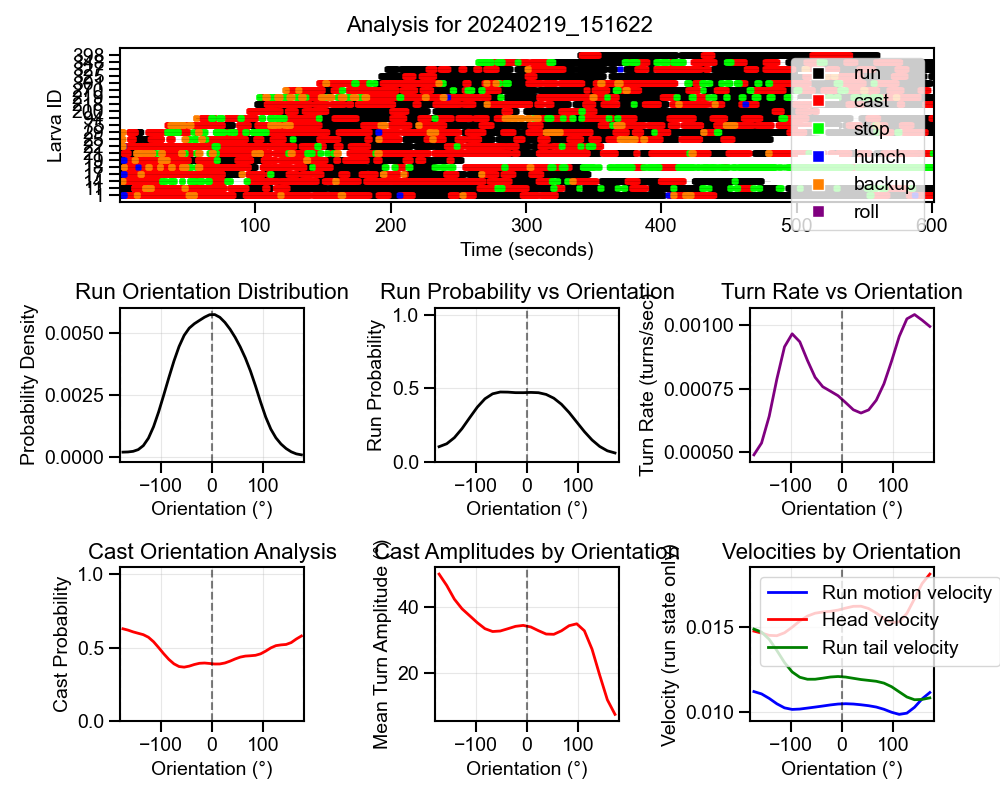

Saved combined analysis to ../results/analysis/GMR_SS00864@UAS_TNT_2_0003/analysis_all_combined.png and ../results/analysis/GMR_SS00864@UAS_TNT_2_0003/analysis_all_combined.pdf


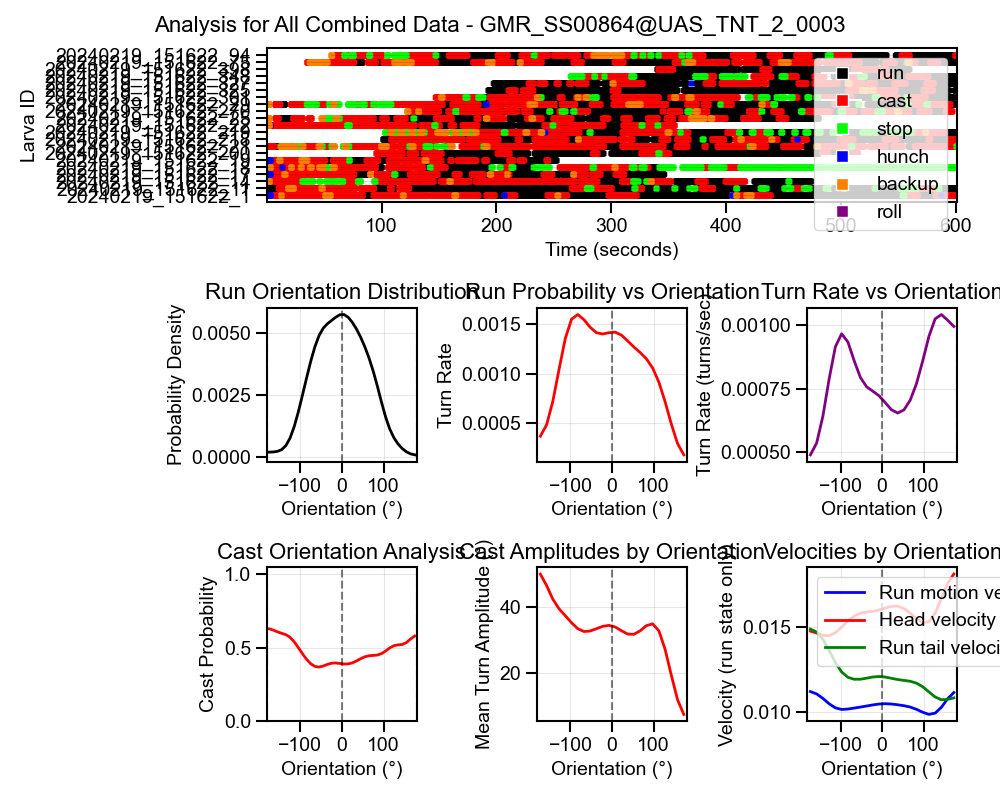

In [9]:
# Plot analysis for each date
for date_key, date_data in all_dates_data.items():
    if date_key != 'all_combined':
        analyze_date(date_data, output_dir)

# Now process the combined data and save it in the genotype root directory
if 'all_combined' in all_dates_data:
    combined_data = all_dates_data['all_combined']
    
    # Create the figure for combined data
    fig = plt.figure(figsize=(10,8))
    fig.suptitle(f"Analysis for All Combined Data - {genotype}", fontsize=16)
    gs = GridSpec(3, 3, figure=fig)
    
    # 1. Ethogram (spans the full first row)
    ax1 = fig.add_subplot(gs[0, :])
    plot_global_behavior_matrix(
        combined_data['merged_data'], show_separate_totals=False, show_plot=False, ax=ax1
    )
    
    # 2. Run orientation distribution
    ax2 = fig.add_subplot(gs[1, 0])
    analyze_run_orientations_all(
        combined_data['merged_data'], show_plot=False, ax=ax2
    )
    ax2.set_title("Run Orientation Distribution")
    
    # 3. Run probability by orientation
    ax3 = fig.add_subplot(gs[1, 1])
    analyze_turn_rate_by_orientation_new(
        combined_data['merged_data'], bin_width=15, show_plot=False, ax=ax3
    )
    ax3.set_title("Run Probability vs Orientation")

    # 4. Turn rate by orientation
    ax4 = fig.add_subplot(gs[1, 2])
    analyze_turn_rate_by_orientation_true(
        combined_data['merged_data'], bin_width=15, show_plot=False, ax=ax4
    )
    ax4.set_title("Turn Rate vs Orientation")

    # 5. Cast orientation analysis
    ax5 = fig.add_subplot(gs[2, 0])
    analyze_cast_orientations_all_true(
        combined_data['merged_data'], show_plot=False, ax=ax5
    )
    ax5.set_title("Cast Orientation Analysis")

    # 6. Cast amplitudes by orientation
    ax6 = fig.add_subplot(gs[2, 1])
    analyze_turn_amplitudes_by_orientation(
        combined_data['merged_data'], bin_width=15, show_plot=False, ax=ax6
    )
    ax6.set_title("Cast Amplitudes by Orientation")
    
    # 7. Velocities by orientation
    ax7 = fig.add_subplot(gs[2, 2])
    analyze_velocity_by_orientation(
        combined_data['merged_data'], bin_width=15, show_plot=False, ax=ax7
    )
    ax7.set_title("Velocities by Orientation")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    
    # Save directly to genotype folder (not in date subfolder)
    save_path_png = os.path.join(output_dir, "analysis_all_combined.png")
    save_path_pdf = os.path.join(output_dir, "analysis_all_combined.pdf")
    plt.savefig(save_path_png)
    plt.savefig(save_path_pdf)
    print(f"Saved combined analysis to {save_path_png} and {save_path_pdf}")
     
    plt.show()

Saved over-time plot to ../results/analysis/GMR_SS00864@UAS_TNT_2_0003/20240219_151622/over_time_20240219_151622.png


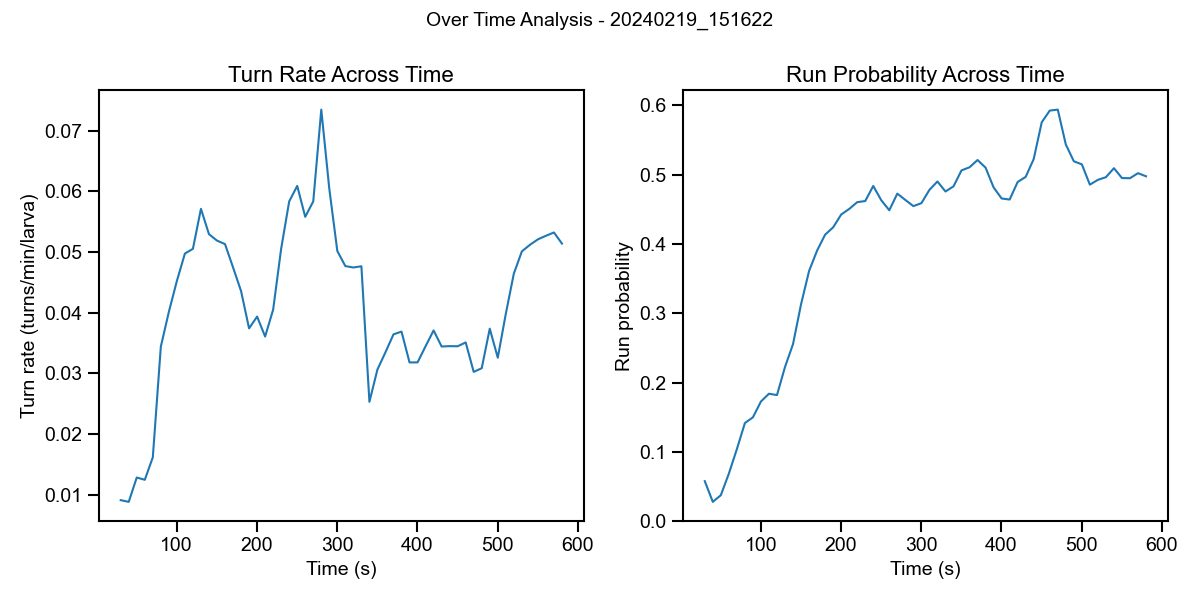

Saved over-time plot to ../results/analysis/GMR_SS00864@UAS_TNT_2_0003/All Combined/over_time_All Combined.png


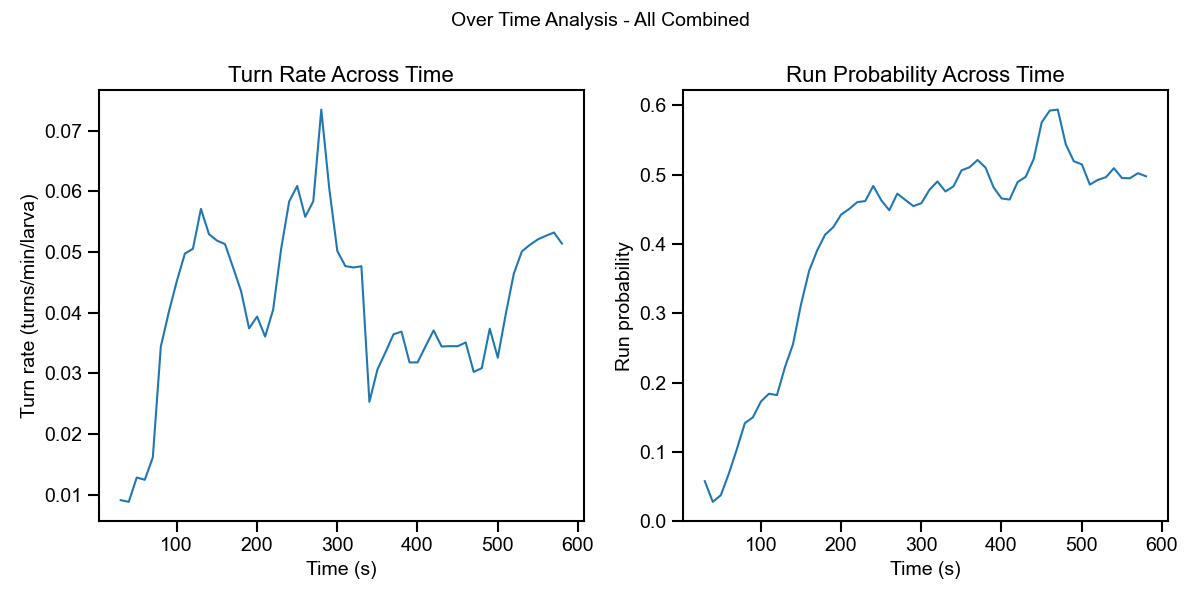

In [10]:
plot_over_time_for_genotype(all_dates_data, window = 60, step = 10, output_dir=output_dir)

## Individual across time

Saved individuals-over-time plot to ../results/analysis/GMR_SS00864@UAS_TNT_2_0003/20240219_151622/individuals_over_time_20240219_151622.png


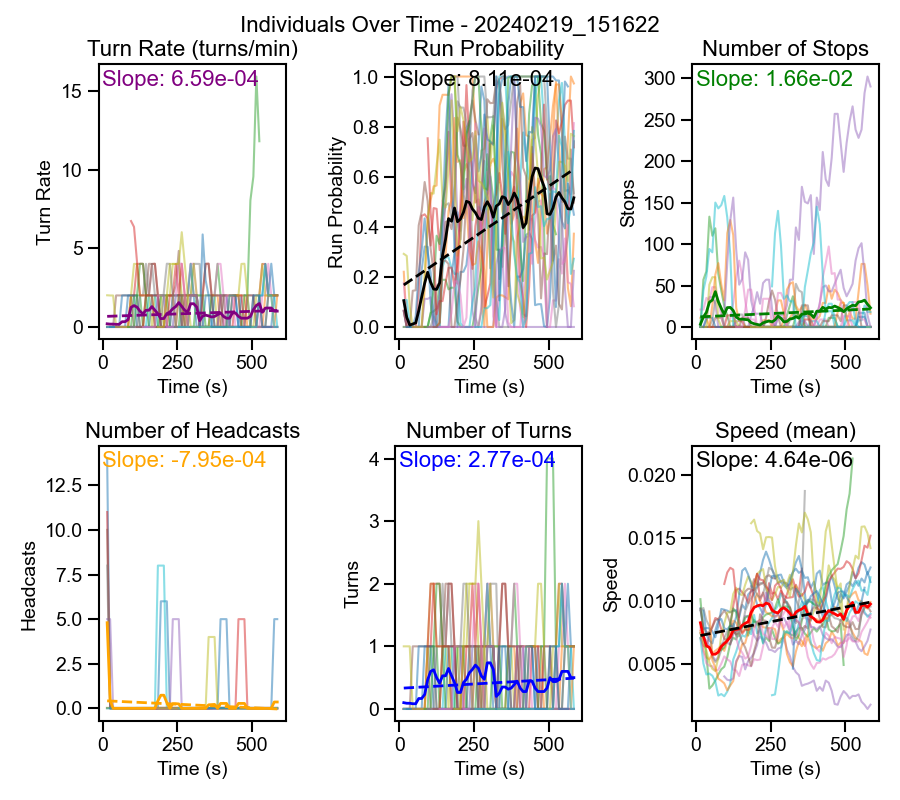

Saved individuals-over-time plot to ../results/analysis/GMR_SS00864@UAS_TNT_2_0003/All Combined/individuals_over_time_All Combined.png


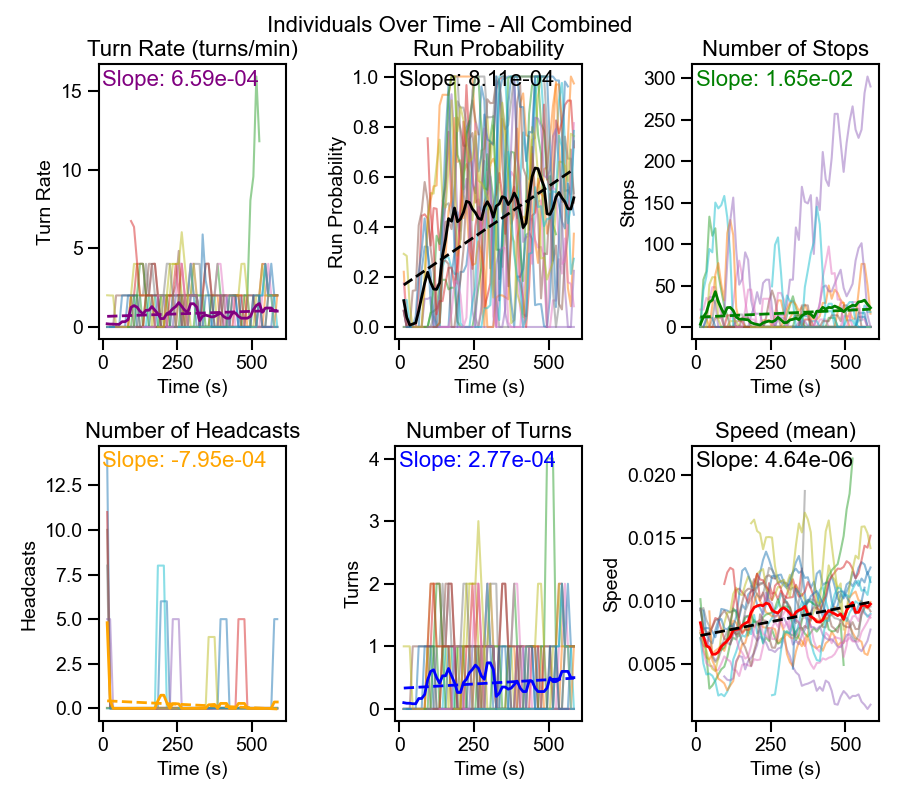

In [11]:
plot_individuals_over_time_absolute_genotype(all_dates_data, window = 30, step = 10, output_dir=output_dir)

<Axes: title={'center': 'Hunch Probability Across Time (All Larvae)'}, xlabel='Time (s)', ylabel='Hunch Probability'>

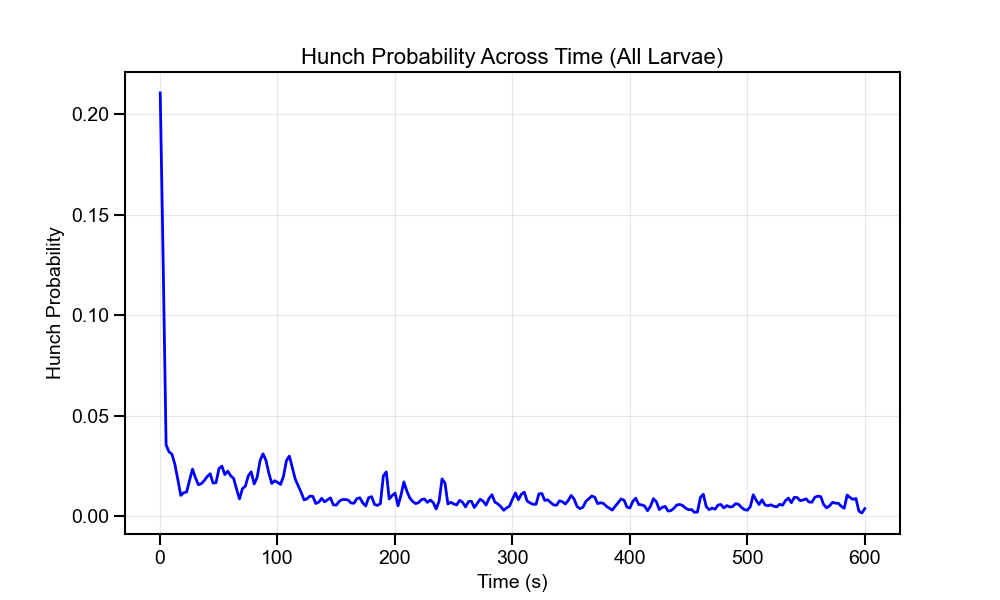

In [12]:
def plot_hunch_probability_all_larvae(trx_data, show_plot=True, ax=None, smooth_window=0.01):
    """
    Plot the hunch probability (P(Hunch)) for all larvae as individual traces across time,
    and overlay the mean hunch probability at each timepoint (nanmean across larvae), smoothed with a moving window.
    Uses the t vector for x-axis and proba_global_state[:, 3] for hunch probability.
    No interpolation; just plot all available data.
    smooth_window: window size in seconds for smoothing the mean trace.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Get larvae data
    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    # Prepare figure
    if ax is None and show_plot:
        fig, ax = plt.subplots(figsize=(10, 6))

    all_hunch = []
    all_t = []

    # Plot each larva's hunch probability
    for larva_id, larva in data_to_process.items():
        if 't' not in larva or 'proba_global_state' not in larva:
            continue
        t = np.array(larva['t']).flatten()
        probs = np.array(larva['proba_global_state'])
        hunch = probs[3, :]
        # ax.plot(t, hunch, alpha=0.1, color='blue')
        all_hunch.append(hunch)
        all_t.append(t)

    # Plot smoothed mean hunch probability using a moving window
    if all_t and all_hunch:
        all_t_concat = np.concatenate(all_t)
        all_hunch_concat = np.concatenate(all_hunch)
        sort_idx = np.argsort(all_t_concat)
        t_sorted = all_t_concat[sort_idx]
        hunch_sorted = all_hunch_concat[sort_idx]

        # Moving window smoothing
        t_min, t_max = np.min(t_sorted), np.max(t_sorted)
        window_centers = np.arange(t_min, t_max, smooth_window/2)
        mean_hunch_smooth = []
        for center in window_centers:
            mask = (t_sorted >= center - smooth_window/2) & (t_sorted < center + smooth_window/2)
            if np.any(mask):
                mean_hunch_smooth.append(np.nanmean(hunch_sorted[mask]))
            else:
                mean_hunch_smooth.append(np.nan)
        ax.plot(window_centers, mean_hunch_smooth, color='blue', linewidth=2)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Hunch Probability')
    ax.set_title('Hunch Probability Across Time (All Larvae)')
    ax.grid(True, alpha=0.3)
    # No legend

    if show_plot and ax is None:
        plt.tight_layout()
        plt.show()

    return ax

# Usage:
plot_hunch_probability_all_larvae(all_dates_data['all_combined']['merged_data'], smooth_window=5)

<Axes: title={'center': 'Total Time in Run and Cast States per Larva (Stacked)'}, ylabel='Time (seconds)'>

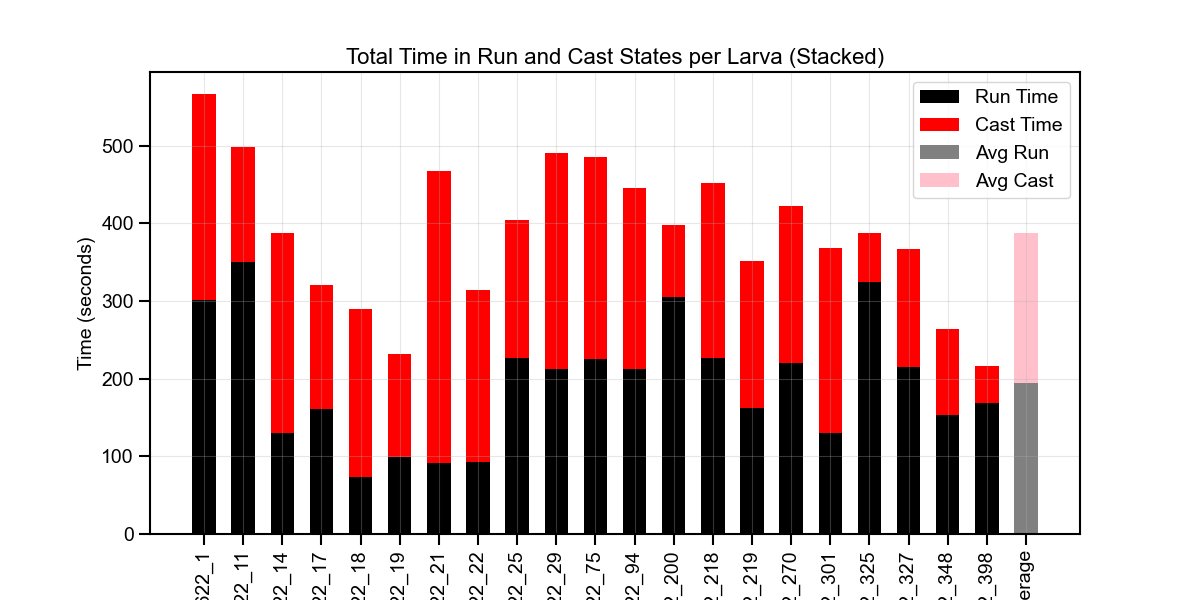

In [13]:
plot_time_in_run_and_cast_stacked(all_dates_data['all_combined']['merged_data'])

In [14]:
# # Create polar run analysis plots
# for date_key, date_data in all_dates_data.items():
#     plt.figure(figsize=(10, 8))
    
#     # Use the merged data for polar analysis
#     merged_data = date_data['merged_data']
    
#     # Create polar plot
#     results = processor.plot_polar_run_histograms(
#         merged_data, 
#         bin_width=5,
#         save_path=os.path.join(output_dir, f"polar_run_{date_key}.png")
#     )
    
#     plt.suptitle(f"Polar Run Analysis - {date_data['date_str']}", fontsize=14)
#     plt.show()

/var/folders/qs/_71td1zx7kjd4t5xhw9wndn00000gp/T/ipykernel_79000/391594544.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


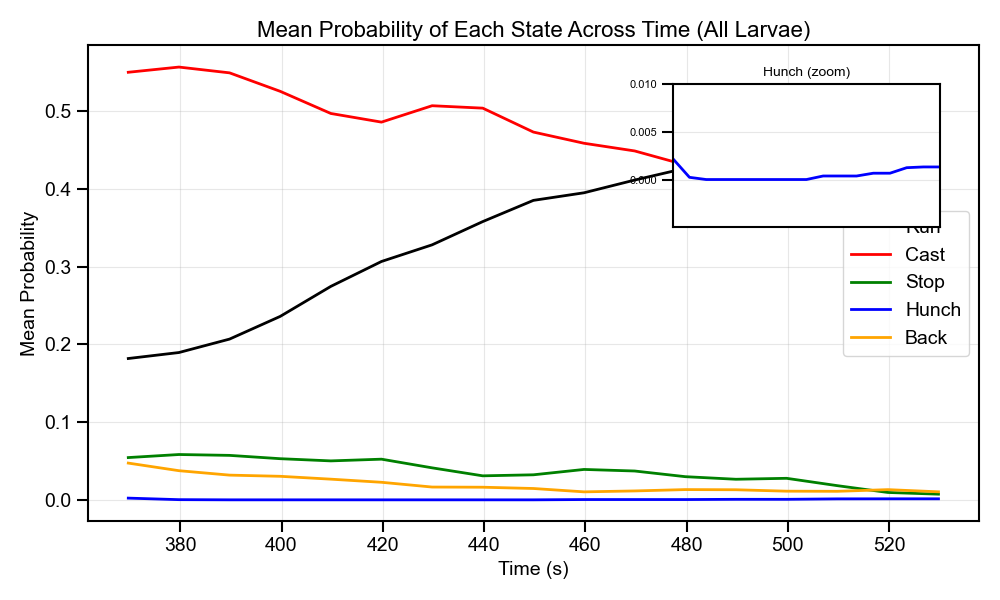

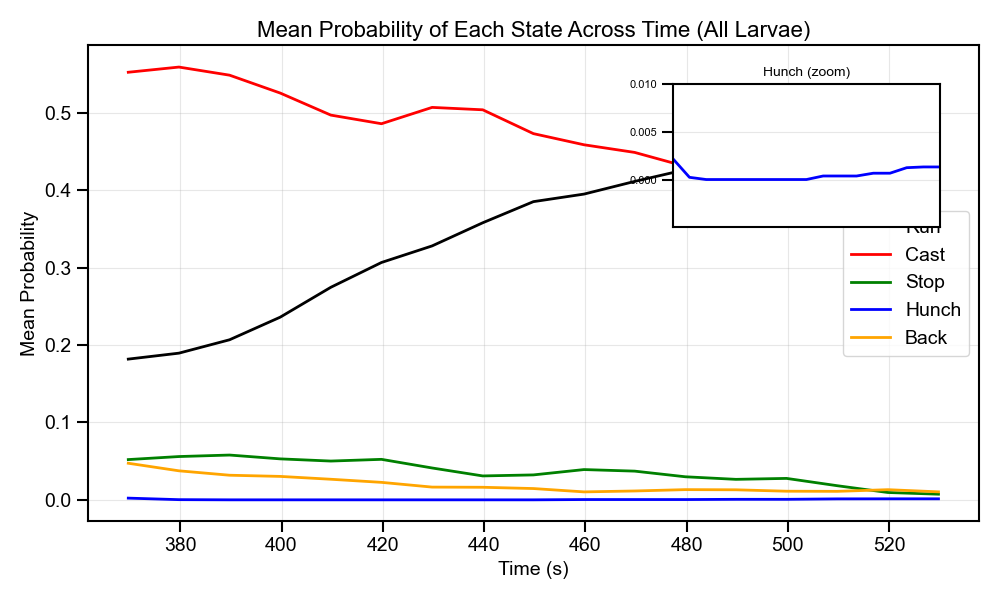

In [15]:
plot_global_state_over_time_genotype(all_dates_data, output_dir=None, show_plot=True, window=60, step=10)

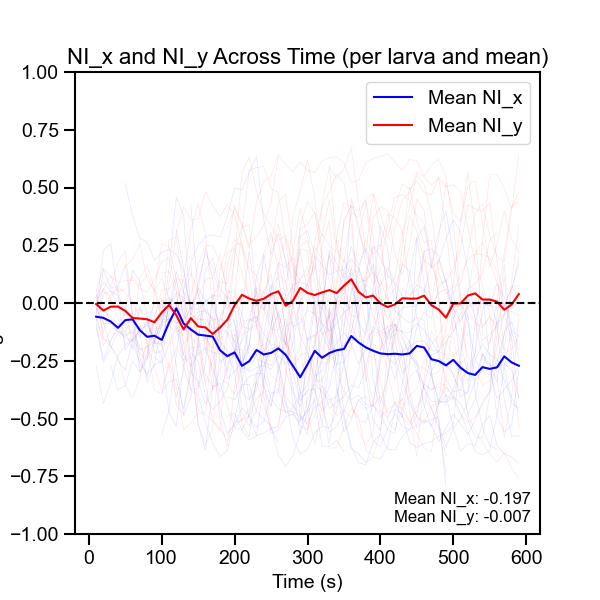

In [16]:
def compute_v_and_axis(trx_data):
    """
    Compute velocity along x and y axes for each larva and store normalized velocities.
    Adds: c_axis_x, c_axis_y, speed, c_axis_x_normalized, c_axis_y_normalized, speed_normalized to each larva.
    Works with {'data': ...} or plain dict.
    """
    import numpy as np

    # Accept both {'data': ...} and plain dict
    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    for larva_id, larva in data_to_process.items():
        # Require t, x_center, y_center, larva_length_smooth_5
        if not all(k in larva for k in ['t', 'x_center', 'y_center', 'larva_length_smooth_5']):
            print(f"Skipping larva {larva_id} due to missing required fields.")
            continue
        t = np.array(larva['t']).flatten()
        x = np.array(larva['x_center']).flatten()
        y = np.array(larva['y_center']).flatten()
        length = np.array(larva['larva_length_smooth_5']).flatten()
        n = min(len(t), len(x), len(y), len(length))
        if n < 2:
            continue
        t = t[:n]
        x = x[:n]
        y = y[:n]
        length = length[:n]

        # Compute velocities (forward difference, last value is nan)
        dt = np.diff(t)
        dx = np.diff(x)
        dy = np.diff(y)
        c_axis_x = np.full(n, np.nan)
        c_axis_y = np.full(n, np.nan)
        speed = np.full(n, np.nan)
        valid = dt > 0
        c_axis_x[:-1][valid] = dx[valid] / dt[valid]
        c_axis_y[:-1][valid] = dy[valid] / dt[valid]
        speed[:-1][valid] = np.sqrt(c_axis_x[:-1][valid]**2 + c_axis_y[:-1][valid]**2)

        # Normalize by mean larva length (ignoring nans)
        mean_size = np.nanmean(length)
        c_axis_x_normalized = c_axis_x / mean_size
        c_axis_y_normalized = c_axis_y / mean_size
        speed_normalized = speed / mean_size

        larva['c_axis_x'] = c_axis_x
        larva['c_axis_y'] = c_axis_y
        larva['speed'] = speed
        larva['c_axis_x_normalized'] = c_axis_x_normalized
        larva['c_axis_y_normalized'] = c_axis_y_normalized
        larva['speed_normalized'] = speed_normalized

    return trx_data


def compute_NI_x_y_over_time(trx_data, window=60, step=10, t_max=600, show_plot=True, ax=None):
    """
    Compute and plot NI_x and NI_y (navigational index in x and y) across time for each larva.
    NI_x = <c_axis_x_normalized> / <speed_normalized> (mean over window)
    NI_y = <c_axis_y_normalized> / <speed_normalized>
    Returns a dict with time bins and NI_x, NI_y arrays (larva x time).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Prepare data
    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    larva_ids = list(data_to_process.keys())
    n_larvae = len(larva_ids)
    time_bins = np.arange(0, t_max - window + step, step) + window / 2
    NI_x_mat = np.full((n_larvae, len(time_bins)), np.nan)
    NI_y_mat = np.full((n_larvae, len(time_bins)), np.nan)

    for i, larva_id in enumerate(larva_ids):
        larva = data_to_process[larva_id]
        t = np.array(larva['t']).flatten()
        c_x = np.array(larva.get('c_axis_x_normalized', []))
        c_y = np.array(larva.get('c_axis_y_normalized', []))
        speed = np.array(larva.get('speed_normalized', []))
        if len(t) < 2 or len(c_x) != len(t):
            continue
        for j, t_center in enumerate(time_bins):
            t0 = t_center - window / 2
            t1 = t_center + window / 2
            mask = (t >= t0) & (t < t1)
            if np.sum(mask) < 2:
                continue
            mean_cx = np.nanmean(c_x[mask])
            mean_cy = np.nanmean(c_y[mask])
            mean_speed = np.nanmean(speed[mask])
            # Correct NI: mean projection divided by mean speed
            NI_x_mat[i, j] = mean_cx / mean_speed if mean_speed != 0 else np.nan
            NI_y_mat[i, j] = mean_cy / mean_speed if mean_speed != 0 else np.nan

    # Plot
    if show_plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(6,6))
        mean_NI_x = np.nanmean(NI_x_mat, axis=0)
        mean_NI_y = np.nanmean(NI_y_mat, axis=0)
        ax.plot(time_bins, mean_NI_x, color='blue', label='Mean NI_x')
        ax.plot(time_bins, mean_NI_y, color='red', label='Mean NI_y')
        for i in range(n_larvae):
            ax.plot(time_bins, NI_x_mat[i], color='blue', alpha=0.1, linewidth=0.5)
            ax.plot(time_bins, NI_y_mat[i], color='red', alpha=0.1, linewidth=0.5)
        ax.axhline(0, color='black', linestyle='--')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Navigational Index')
        ax.set_title('NI_x and NI_y Across Time (per larva and mean)')
        ax.set_ylim(-1, 1)
        ax.legend()
        mean_NI_x_val = np.nanmean(mean_NI_x)
        mean_NI_y_val = np.nanmean(mean_NI_y)
        ax.text(
            0.98, 0.02,
            f"Mean NI_x: {mean_NI_x_val:.3f}\nMean NI_y: {mean_NI_y_val:.3f}",
            ha='right', va='bottom', transform=ax.transAxes,
            fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )
        if ax is None:
            plt.tight_layout()
            plt.show()

    return {
        'time_bins': time_bins,
        'NI_x_mat': NI_x_mat,
        'NI_y_mat': NI_y_mat,
        'mean_NI_x': np.nanmean(NI_x_mat, axis=0),
        'mean_NI_y': np.nanmean(NI_y_mat, axis=0),
        'larva_ids': larva_ids
    }
# Example usage:

all_dates_data['all_combined']['merged_data'] = compute_v_and_axis(all_dates_data['all_combined']['merged_data'])
result = compute_NI_x_y_over_time(all_dates_data['all_combined']['merged_data'], window=20, step=10, t_max=600)

In [17]:
def save_NI_x_y_plot(trx_data, output_dir, date_str, window=20, step=10, t_max=600):
    """
    Compute and save NI_x and NI_y plot for a given trx_data (merged_data), saving to output_dir/date_str/.
    """
    import os
    import matplotlib.pyplot as plt

    # Ensure velocity fields are present
    trx_data = compute_v_and_axis(trx_data)
    # Compute NI_x and NI_y and plot
    fig, ax = plt.subplots(figsize=(6, 6))
    compute_NI_x_y_over_time(trx_data, window=window, step=step, t_max=t_max, show_plot=True, ax=ax)
    # Save
    date_dir = os.path.join(output_dir, date_str)
    os.makedirs(date_dir, exist_ok=True)
    save_path_png = os.path.join(date_dir, f"NI_x_y_over_time_{date_str}.png")
    save_path_pdf = os.path.join(date_dir, f"NI_x_y_over_time_{date_str}.pdf")
    plt.savefig(save_path_png)
    plt.savefig(save_path_pdf)
    plt.close(fig)
    print(f"Saved NI_x/NI_y plot to {save_path_png} and {save_path_pdf}")

# Save for all_combined
if 'all_combined' in all_dates_data:
    save_NI_x_y_plot(
        all_dates_data['all_combined']['merged_data'],
        output_dir,
        'all_combined',
        window=20, step=10, t_max=600
    )

# Save for each individual date
for date_key, date_data in all_dates_data.items():
    if date_key == 'all_combined':
        continue
    save_NI_x_y_plot(
        date_data['merged_data'],
        output_dir,
        date_data['date_str'],
        window=20, step=10, t_max=600
    )
    analyze_velocity_by_orientation

def compute_dispersion(trx_data, center_type='vertical', center_value=None):
    """
    Compute the dispersion (spread) of larvae away from a central reference.
    - center_type: 'vertical' (default) or 'point'
        - 'vertical': computes distance from a vertical line x=center_value (default: mean of all starting x)
        - 'point': computes distance from a point (center_value: (x0, y0), default: mean of all starting positions)
    Returns:
        dispersion_dict: {larva_id: {'dispersion': value, 'distances': array, 'center': ...}}
    """
    import numpy as np

    # Accept both {'data': ...} and plain dict
    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    # Gather all starting positions
    start_xs = []
    start_ys = []
    for larva in data_to_process.values():
        if 'x_center' in larva and 'y_center' in larva:
            x = np.array(larva['x_center']).flatten()
            y = np.array(larva['y_center']).flatten()
            if len(x) > 0 and len(y) > 0:
                start_xs.append(x[0])
                start_ys.append(y[0])

    # Default center
    if center_type == 'vertical':
        if center_value is None:
            center_value = np.mean(start_xs) if start_xs else 0.0
        center = center_value
    elif center_type == 'point':
        if center_value is None:
            center_value = (np.mean(start_xs), np.mean(start_ys)) if start_xs and start_ys else (0.0, 0.0)
        center = center_value
    else:
        raise ValueError("center_type must be 'vertical' or 'point'")

    dispersion_dict = {}
    for larva_id, larva in data_to_process.items():
        if 'x_center' not in larva or 'y_center' not in larva:
            continue
        x = np.array(larva['x_center']).flatten()
        y = np.array(larva['y_center']).flatten()
        if len(x) == 0 or len(y) == 0:
            continue

        if center_type == 'vertical':
            distances = np.abs(x - center)
        elif center_type == 'point':
            distances = np.sqrt((x - center[0])**2 + (y - center[1])**2)

        dispersion = np.std(distances)
        dispersion_dict[larva_id] = {
            'dispersion': dispersion,
            'distances': distances,
            'center': center
        }
    return dispersion_dict
    

Saved NI_x/NI_y plot to ../results/analysis/GMR_SS00864@UAS_TNT_2_0003/all_combined/NI_x_y_over_time_all_combined.png and ../results/analysis/GMR_SS00864@UAS_TNT_2_0003/all_combined/NI_x_y_over_time_all_combined.pdf
Saved NI_x/NI_y plot to ../results/analysis/GMR_SS00864@UAS_TNT_2_0003/20240219_151622/NI_x_y_over_time_20240219_151622.png and ../results/analysis/GMR_SS00864@UAS_TNT_2_0003/20240219_151622/NI_x_y_over_time_20240219_151622.pdf


Saved dispersion plot to ../results/analysis/GMR_SS00864@UAS_TNT_2_0003/dispersion_over_time_all_combined.png


/var/folders/qs/_71td1zx7kjd4t5xhw9wndn00000gp/T/ipykernel_79000/396633409.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


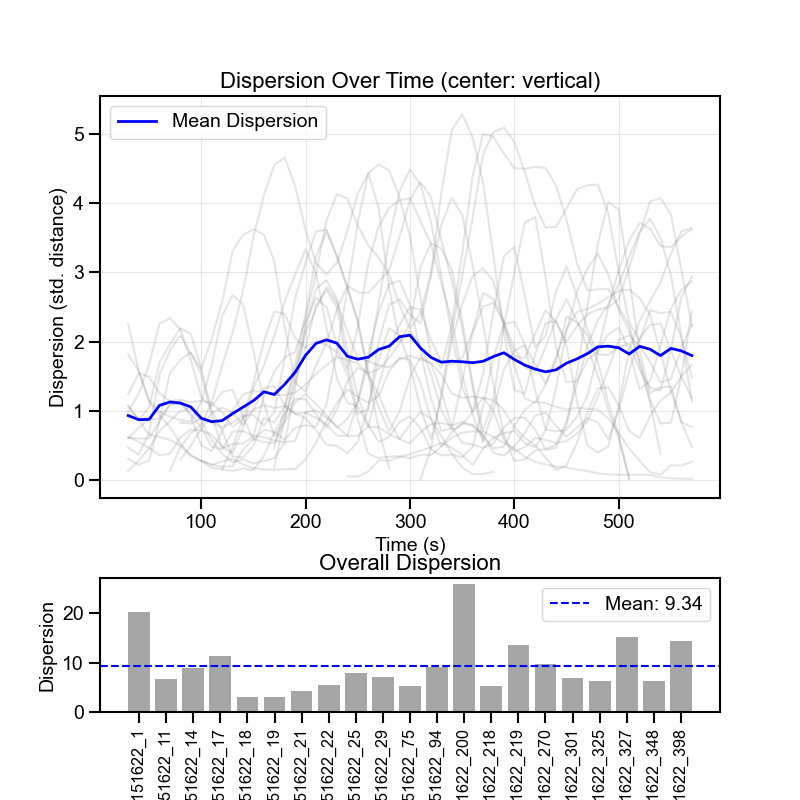

In [18]:
def compute_dispersion_over_time(trx_data, window=60, step=10, t_max=600, center_type='vertical', center_value=None):
    """
    Compute dispersion over time for each larva.
    Returns:
        {
            'time_bins': array,
            'dispersion_mat': (n_larvae, n_time_bins) array,
            'larva_ids': list,
            'center': value
        }
    """
    import numpy as np

    # Accept both {'data': ...} and plain dict
    if 'data' in trx_data:
        data_to_process = trx_data['data']
    else:
        data_to_process = trx_data

    # Gather all starting positions for default center
    start_xs, start_ys = [], []
    for larva in data_to_process.values():
        if 'x_center' in larva and 'y_center' in larva:
            x = np.array(larva['x_center']).flatten()
            y = np.array(larva['y_center']).flatten()
            if len(x) > 0 and len(y) > 0:
                start_xs.append(x[0])
                start_ys.append(y[0])
    # Default center
    if center_type == 'vertical':
        if center_value is None:
            center_value = np.mean(start_xs) if start_xs else 0.0
        center = center_value
    elif center_type == 'point':
        if center_value is None:
            center_value = (np.mean(start_xs), np.mean(start_ys)) if start_xs and start_ys else (0.0, 0.0)
        center = center_value
    else:
        raise ValueError("center_type must be 'vertical' or 'point'")

    larva_ids = list(data_to_process.keys())
    n_larvae = len(larva_ids)
    time_bins = np.arange(0, t_max - window + step, step) + window / 2
    dispersion_mat = np.full((n_larvae, len(time_bins)), np.nan)

    for i, larva_id in enumerate(larva_ids):
        larva = data_to_process[larva_id]
        if 't' not in larva or 'x_center' not in larva or 'y_center' not in larva:
            continue
        t = np.array(larva['t']).flatten()
        x = np.array(larva['x_center']).flatten()
        y = np.array(larva['y_center']).flatten()
        n = min(len(t), len(x), len(y))
        if n < 2:
            continue
        t, x, y = t[:n], x[:n], y[:n]
        for j, t_center in enumerate(time_bins):
            t0 = t_center - window / 2
            t1 = t_center + window / 2
            mask = (t >= t0) & (t < t1)
            if np.sum(mask) < 2:
                continue
            if center_type == 'vertical':
                distances = np.abs(x[mask] - center)
            elif center_type == 'point':
                distances = np.sqrt((x[mask] - center[0])**2 + (y[mask] - center[1])**2)
            dispersion_mat[i, j] = np.std(distances)
    return {
        'time_bins': time_bins,
        'dispersion_mat': dispersion_mat,
        'larva_ids': larva_ids,
        'center': center
    }

def plot_dispersion_over_time_with_overall(
    trx_data, window=60, step=10, t_max=600, center_type='vertical', center_value=None, show_plot=True, save_path=None
):
    """
    Plot dispersion over time for all larvae and mean, with overall dispersion as a small subplot below.
    If save_path is given, saves the figure there.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    # Compute over-time dispersion
    result = compute_dispersion_over_time(trx_data, window, step, t_max, center_type, center_value)
    time_bins = result['time_bins']
    disp_mat = result['dispersion_mat']
    larva_ids = result['larva_ids']

    # Compute overall dispersion
    disp_dict = compute_dispersion(trx_data, center_type=center_type, center_value=center_value)
    dispersions = [disp_dict[lid]['dispersion'] for lid in larva_ids]
    mean_disp = np.mean(dispersions)

    # Create figure with two subplots (main + small below)
    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)
    ax_main = fig.add_subplot(gs[0])
    ax_overall = fig.add_subplot(gs[1])

    # Main plot: dispersion over time
    for i in range(len(larva_ids)):
        ax_main.plot(time_bins, disp_mat[i], alpha=0.2, color='gray')
    mean_disp_time = np.nanmean(disp_mat, axis=0)
    ax_main.plot(time_bins, mean_disp_time, color='blue', linewidth=2, label='Mean Dispersion')
    ax_main.set_xlabel('Time (s)')
    ax_main.set_ylabel('Dispersion (std. distance)')
    ax_main.set_title(f'Dispersion Over Time (center: {center_type})')
    ax_main.grid(True, alpha=0.3)
    ax_main.legend()

    # Small subplot: overall dispersion bar plot
    ax_overall.bar(larva_ids, dispersions, color='gray', alpha=0.7)
    ax_overall.axhline(mean_disp, color='blue', linestyle='--', label=f'Mean: {mean_disp:.2f}')
    ax_overall.set_ylabel('Dispersion')
    ax_overall.set_xlabel('Larva ID')
    ax_overall.set_title('Overall Dispersion')
    ax_overall.legend()
    ax_overall.set_xticks(range(len(larva_ids)))
    ax_overall.set_xticklabels(larva_ids, rotation=90, fontsize='small')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Saved dispersion plot to {save_path}")
    if show_plot:
        plt.show()
    return fig

# Example usage:
# Save in the same folder as NI_x_y plot
if 'all_combined' in all_dates_data:
    save_path = os.path.join(output_dir, "dispersion_over_time_all_combined.png")
    plot_dispersion_over_time_with_overall(
        all_dates_data['all_combined']['merged_data'],
        window=60, step=10, t_max=600,
        center_type='vertical',
        show_plot=True,
        save_path=save_path
    )

# --- Explanation ---
# Dispersion is calculated as follows:
# - For each larva, at each time window, compute the distance from the larva's position to a central reference
#   (either a vertical line or a point).
# - The standard deviation of these distances within the window is the dispersion for that larva and window.
# - "Dispersion over time" shows how this spread evolves.
# - "Overall dispersion" is the standard deviation of all distances for each larva over the whole experiment.